# Code for all plots on paper

## Figure 2

### Figure 2a - Naive Counts vs. Ground truth 

In [1]:
from umi_utils import non_unif_forward_model

In [2]:
umi_prob_dict = {}
for i in range(1, 13):
    umi_prob_dict[i] = pd.read_csv(f"/data/dagyeman/cellranger/bam_file_analysis/data/umi_probs/umi_probs_{i}.csv")

umi_probs = umi_prob_dict[j]["prob"]

print(len(umi_probs))

1024


In [3]:
print("umi_probs: ", type(umi_probs))
if hasattr(umi_probs, "values"):  # pandas object?
    print("umi_probs.values ->", type(umi_probs.values), umi_probs.values.shape, umi_probs.values.dtype)

probs = np.asarray(umi_probs)
print("probs (np.asarray):", type(probs), probs.shape, probs.dtype)
print("probs flags: C_CONTIGUOUS=", np.ascontiguousarray(probs).flags['C_CONTIGUOUS'],
      "F_CONTIGUOUS=", probs.flags['F_CONTIGUOUS'])

print("n_values:", type(n_values))
n_vals = np.asarray(n_values)
print("n_values (np.asarray):", type(n_vals), n_vals.shape, n_vals.dtype)


umi_probs:  <class 'pandas.core.series.Series'>
umi_probs.values -> <class 'numpy.ndarray'> (1024,) float64
probs (np.asarray): <class 'numpy.ndarray'> (1024,) float64
probs flags: C_CONTIGUOUS= True F_CONTIGUOUS= True
n_values: <class 'numpy.ndarray'>
n_values (np.asarray): <class 'numpy.ndarray'> (200,) float64


Total common barcodes: 5709
Total filtered gene counts (post-remove): 19846727


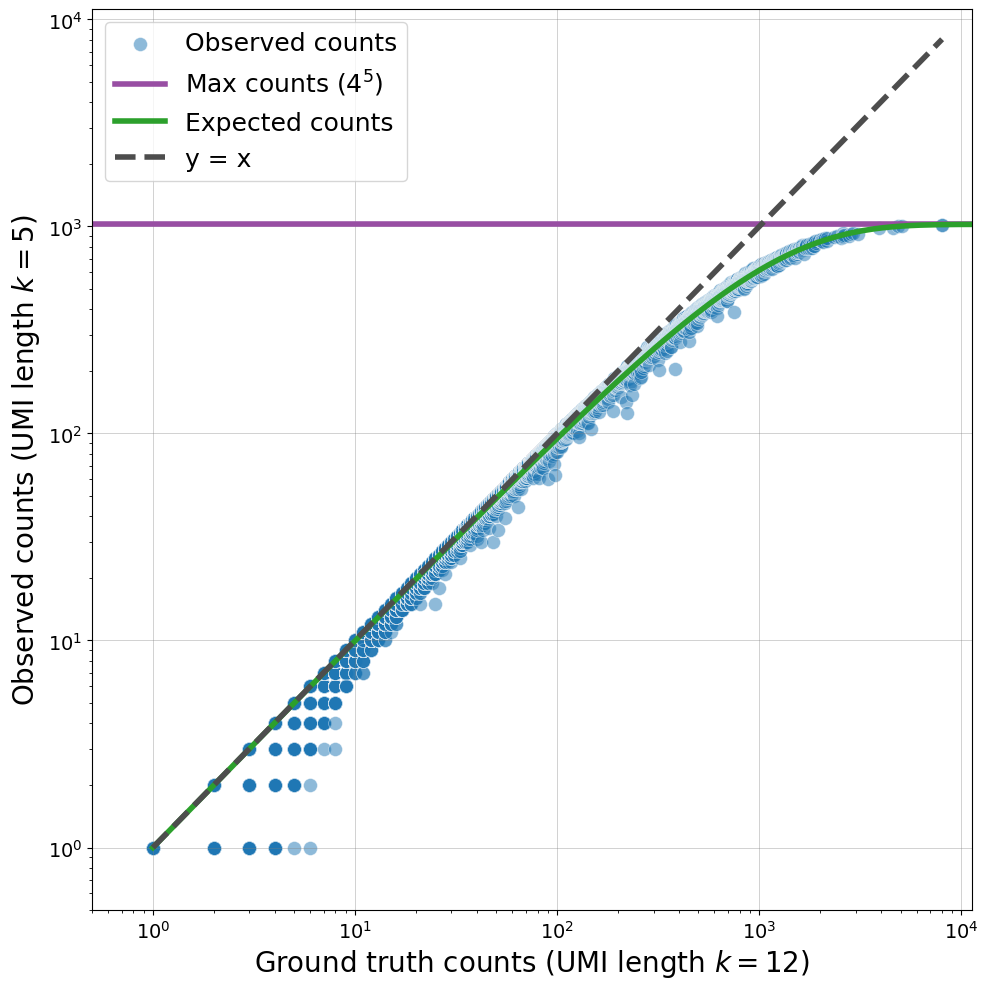

In [12]:
import os
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import scipy.sparse as sp
from umi_utils import non_unif_forward_model
import pandas as pd



# Define which genes to remove
remove = np.array([
    "MALAT1",
    # add any other gene names you want to drop here
])

dataset = "5k_PBMCs"  # Change to "1k_PBMCs" if needed

adata_dict = {}
adata_path = f"/data/dagyeman/cellranger/bam_file_analysis/{dataset}/ub_objects/adata_matrices"

# --- Load only what you actually use (i=12, j=5) ---
i = 12
j = 5
adata_dict[i] = sc.read_h5ad(f"{adata_path}/adata_{i}.h5ad")
adata_dict[j] = sc.read_h5ad(f"{adata_path}/adata_{j}.h5ad")


umi_prob_dict = {}
for i in range(1, 13):
    umi_prob_dict[i] = pd.read_csv(f"/data/dagyeman/cellranger/bam_file_analysis/data/umi_probs/umi_probs_{i}.csv")

umi_probs = umi_prob_dict[j]["prob"]


# Align barcodes
common_barcodes = sorted(
    set(adata_dict[i].obs_names).intersection(set(adata_dict[j].obs_names))
)
print(f"Total common barcodes: {len(common_barcodes)}")

indices_i = adata_dict[i].obs_names.get_indexer(common_barcodes)
indices_j = adata_dict[j].obs_names.get_indexer(common_barcodes)

# Gene mask
gene_mask = ~np.isin(adata_dict[i].var_names, remove)

X_i = adata_dict[i].X[indices_i][:, gene_mask]
X_j = adata_dict[j].X[indices_j][:, gene_mask]

# ---------- FILTER (simplified) ----------
# Keep only pairs with X_i >= 1 (no filter on X_j)
X_i = np.asarray(X_i.todense() if sp.issparse(X_i) else X_i)
X_j = np.asarray(X_j.todense() if sp.issparse(X_j) else X_j)

mask = (X_i >= 1)
filtered_counts_i = X_i[mask]
filtered_counts_j = X_j[mask]

all_gene_counts_i = np.array(filtered_counts_i)
all_gene_counts_j = np.array(filtered_counts_j)

print(f"Total filtered gene counts (post-remove): {len(all_gene_counts_i)}")

# Sort by GT counts and apply the same order to observed counts
sorted_indices = np.argsort(all_gene_counts_i)
sorted_gene_counts_i = all_gene_counts_i[sorted_indices]
sorted_gene_counts_j = all_gene_counts_j[sorted_indices]

# Plot
plt.figure(figsize=(10, 10))
plt.scatter(
    sorted_gene_counts_i, 
    sorted_gene_counts_j, 
    alpha=0.5, 
    c='#1f77b4',
    edgecolors='w', 
    s=100,
    linewidth=0.5, 
    label='Observed counts'
)

y_asymptotic_value = 4**j
plt.axhline(
    y=y_asymptotic_value, 
    color='#984ea3', 
    linestyle='-', 
    linewidth=4, 
    label=f'Max counts ($4^{{{j}}}$)'
)

# --- Forward model line: expected observed counts vs true counts n ---
# Avoid broadcasting error by evaluating the JIT function per-scalar n and stacking.
probs = umi_probs.values.astype(float)
sv = 1.4
n_values = np.logspace(0, np.log(sorted_gene_counts_i.max()*sv), 200)
n_values = n_values.astype(float)
model_vals = np.array([non_unif_forward_model(float(n), probs, 4**j) for n in n_values])

plt.plot(
    n_values, 
    model_vals, 
    color='#2ca02c',
    linewidth=4, 
    label='Expected counts'
)

max_val = sorted_gene_counts_i.max()
plt.plot([1, max_val], [1, max_val], linestyle='--', color='#4D4D4D', linewidth=4, label='y = x')

plt.xscale('log')
plt.yscale('log')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlim(0.5, max_val*sv)
plt.ylim(0.5, max_val*sv)
plt.ylabel(r"Observed counts (UMI length $k=5$)", fontsize=20)
plt.xlabel(r"Ground truth counts (UMI length $k=12$)", fontsize=20)
plt.grid(True, linestyle='-', linewidth=0.5, color='gray', alpha=0.5)
plt.legend(loc="upper left", fontsize=18)

plt.tight_layout()
plt.savefig(f"/data/dagyeman/cellranger/bam_file_analysis/figures/{dataset}/{dataset}_obs_vs_gt_counts.jpeg", dpi=300)
plt.show()
plt.close()




### Figure 2b - Predicted Counts vs Ground Truth 

Total common barcodes: 5709
Total filtered gene counts: 19846727


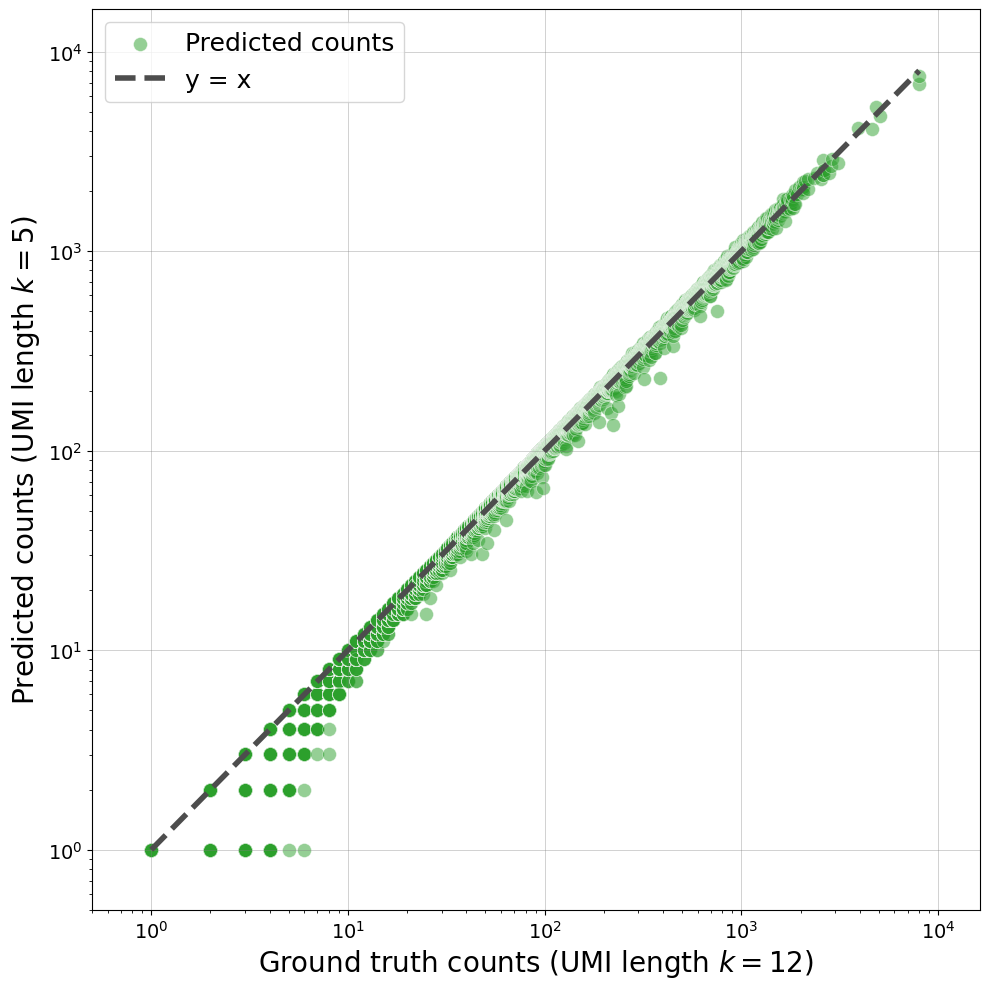

In [13]:
import os
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc

# dataset = "1k_PBMCs" 
dataset = "5k_PBMCs" 

adata_12 = sc.read_h5ad(
    f"/data/dagyeman/cellranger/bam_file_analysis/{dataset}/ub_objects/adata_matrices/adata_12.h5ad"
)

# Only load what you use (j=5) to avoid unnecessary I/O
adata_dict = {}
j = 5
adata_dict[j] = sc.read_h5ad(
    f"/data/dagyeman/cellranger/bam_file_analysis/{dataset}/ub_objects/col_aware_nunif_matrices/adata_{j}.h5ad"
)

# Define which genes to remove
remove = np.array([
    "MALAT1",
    # add any other gene names you want to drop here
])


# Fixed UMI length for "true" counts
i = 12
n_values = np.logspace(0, 4.5, 200)

# Ensure both datasets are properly aligned (fast indexer; no O(n^2) list.index)
common_barcodes = sorted(set(adata_12.obs_names).intersection(set(adata_dict[j].obs_names)))
print(f"Total common barcodes: {len(common_barcodes)}")

indices_i = adata_12.obs_names.get_indexer(common_barcodes)
indices_j = adata_dict[j].obs_names.get_indexer(common_barcodes)

# Create a mask for genes to **keep** (i.e. not in 'remove')
gene_mask = ~np.isin(np.asarray(adata_12.var_names), remove)

# Pull full matrices at once, subsetting both cells and genes
X_i = adata_12.X[indices_i][:, gene_mask]
X_j = adata_dict[j].X[indices_j][:, gene_mask]

# ---- FILTER (dense path only) ----
mask = X_i >= 1
filtered_counts_i = X_i[mask]
filtered_counts_j = X_j[mask]

# Convert to numpy arrays (kept for parity)
all_gene_counts_i = np.array(filtered_counts_i)
all_gene_counts_j = np.array(filtered_counts_j)

print(f"Total filtered gene counts: {len(all_gene_counts_i)}")

# Sort by the "ground truth" values exactly as you did
sorted_indices = np.argsort(all_gene_counts_i)
sorted_gene_counts_i = all_gene_counts_i[sorted_indices]
sorted_gene_counts_j = all_gene_counts_j[sorted_indices]

# Create plot (styling preserved)
plt.figure(figsize=(10, 10))
plt.scatter(
    sorted_gene_counts_i, 
    sorted_gene_counts_j, 
    alpha=0.5, 
    c='#2ca02c',     # Standard Green for Points (kept)
    edgecolors='w', 
    s=100,           
    linewidth=0.5, 
    label='Predicted counts'
)
sv = 1.3
# Reference y = x line
max_val = sorted_gene_counts_i.max()
plt.plot([1, max_val], [1, max_val], linestyle='--', color='#4D4D4D', linewidth=4, label='y = x')

plt.xscale('log')
plt.yscale('log')
ymin, ymax = plt.ylim()
plt.ylim(0.5, ymax*sv)
plt.xlim(0.5, ymax*sv)
plt.ylabel(r"Predicted counts (UMI length $k=5$)", fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14) 
plt.xlabel(r"Ground truth counts (UMI length $k=12$)", fontsize=20)
plt.grid(True, linestyle='-', linewidth=0.5, color='gray', alpha=0.5)
plt.legend(loc="upper left", fontsize=18)

plt.tight_layout()
plt.savefig(
    f"/data/dagyeman/cellranger/bam_file_analysis/figures/{dataset}/{dataset}_pred_vs_gt_counts.jpeg", 
    dpi=300
)
plt.show()
plt.close()



### Figure 2c - Naive vs MSE Errors

[1.2421035098844552e-07, 1.0375453709528327e-07, 7.450912003182396e-08, 3.354508529617945e-08, 5.887031673568188e-09, 6.060233923291756e-10, 6.423981725589057e-11, 1.0637764791416645e-11, 3.922400432009896e-12, 1.853362100407416e-12, 6.86587059906413e-13, 0.0]
[1.1799715810582631e-07, 7.818285371118655e-08, 1.456075172120403e-08, 4.415468698791146e-10, 7.017065623118794e-11, 1.8011636449811536e-11, 7.609133185050826e-12, 4.429154192731574e-12, 2.947792775395499e-12, 1.6841718740362536e-12, 6.596943531331015e-13, 0.0]


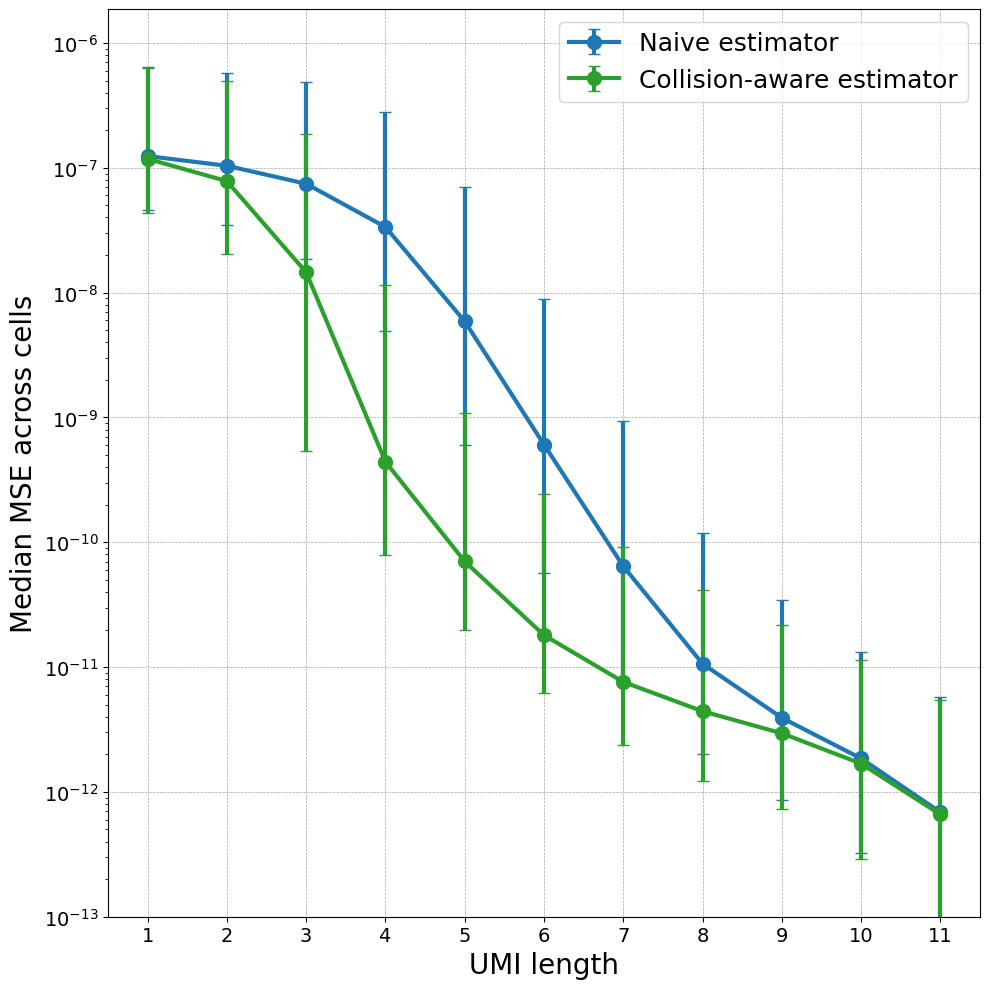

In [14]:
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
dataset = "5k_PBMCs"  # Change to "10k_PBMCs" for the 10k dataset


remove = np.array(['MALAT1'])  # remove MALAT1

# Loading the regular adata matrices
common_path = f"/data/dagyeman/cellranger/bam_file_analysis/{dataset}/ub_objects/adata_matrices"
regular_adata_dict = {}
for i in range(1, 13):
    path = f"{common_path}/adata_{i}.h5ad"
    adata = sc.read_h5ad(path)
    adata = adata[:, ~np.in1d(adata.var_names, remove)].copy()
    regular_adata_dict[i] = adata

# (REMOVED) Loading the collision-aware uniform matrices

# Loading the collision-aware non-uniform matrices  (will become "...2")
common_path3 = f"/data/dagyeman/cellranger/bam_file_analysis/{dataset}/ub_objects/col_aware_nunif_matrices"
non_unif_adata_dict = {}
for i in range(1, 12):
    path = f"{common_path3}/adata_{i}.h5ad"
    adata = sc.read_h5ad(path)
    adata = adata[:, ~np.in1d(adata.var_names, remove)].copy()
    non_unif_adata_dict[i] = adata
adata = sc.read_h5ad(f"{common_path}/adata_12.h5ad")
adata = adata[:, ~np.in1d(adata.var_names, remove)].copy()
non_unif_adata_dict[12] = adata

# This is the ground truth adata matrix
gt_adata12 = regular_adata_dict[12]

# Initialize lists to store the median and (2.5%, 97.5%) CI distances
median_errors, ci_low_errors, ci_high_errors = [], [], []
median_errors2, ci_low_errors2, ci_high_errors2 = [], [], []

# Compute MSE (on row-normalized vectors) for regular and non-uniform matrices against the ground truth
for i in range(1, 13):
    # --- Regular vs GT ---
    common_cells = [c for c in gt_adata12.obs_names if c in regular_adata_dict[i].obs_names]
    common_genes = [g for g in gt_adata12.var_names if g in regular_adata_dict[i].var_names]
    reg_mat = regular_adata_dict[i][common_cells, common_genes].X
    gt_mat  = gt_adata12[common_cells, common_genes].X
    reg_mat = reg_mat.toarray() if hasattr(reg_mat, "toarray") else np.asarray(reg_mat)
    gt_mat  = gt_mat.toarray()  if hasattr(gt_mat,  "toarray") else np.asarray(gt_mat)
    reg_mat = reg_mat.astype(np.float64, copy=False)
    gt_mat  = gt_mat.astype(np.float64, copy=False)
    # Mask: only genes with GT >= 1
    mask = (gt_mat >= 1.0)
    reg_mat = reg_mat * mask
    gt_mat  = gt_mat  * mask
    # Row-normalize to probabilities
    sum_reg = reg_mat.sum(axis=1, keepdims=True)
    sum_gt  = gt_mat.sum(axis=1, keepdims=True)
    reg_norm = reg_mat / sum_reg
    gt_norm  = gt_mat  / sum_gt
    # Per-row MSE (average across genes), then aggregate
    per_row_mse = np.mean((reg_norm - gt_norm) ** 2, axis=1)
    med = float(np.median(per_row_mse))
    q_low, q_high = np.percentile(per_row_mse, [2.5, 97.5])
    median_errors.append(med)
    ci_low_errors.append(med - q_low)
    ci_high_errors.append(q_high - med)

    # --- Non-uniform inverted vs GT ---
    common_cells = [c for c in gt_adata12.obs_names if c in non_unif_adata_dict[i].obs_names]
    common_genes = [g for g in gt_adata12.var_names if g in non_unif_adata_dict[i].var_names]
    nonunif_mat = non_unif_adata_dict[i][common_cells, common_genes].X
    gt_mat      = gt_adata12[common_cells, common_genes].X
    nonunif_mat = nonunif_mat.toarray() if hasattr(nonunif_mat, "toarray") else np.asarray(nonunif_mat)
    gt_mat      = gt_mat.toarray()      if hasattr(gt_mat,  "toarray") else np.asarray(gt_mat)
    nonunif_mat = nonunif_mat.astype(np.float64, copy=False)
    gt_mat      = gt_mat.astype(np.float64, copy=False)
    mask = (gt_mat >= 1.0)
    nonunif_mat = nonunif_mat * mask
    gt_mat      = gt_mat      * mask
    sum_non = nonunif_mat.sum(axis=1, keepdims=True)
    sum_gt  = gt_mat.sum(axis=1, keepdims=True)
    nonunif_norm = nonunif_mat / sum_non
    gt_norm      = gt_mat      / sum_gt
    # Per-row MSE (average across genes), then aggregate
    per_row_mse2 = np.mean((nonunif_norm - gt_norm) ** 2, axis=1)
    med2 = float(np.median(per_row_mse2))
    q_low2, q_high2 = np.percentile(per_row_mse2, [2.5, 97.5])
    median_errors2.append(med2)
    ci_low_errors2.append(med2 - q_low2)
    ci_high_errors2.append(q_high2 - med2)

print(median_errors)
print(median_errors2)

# Plotting the errors (median with 2.5%/97.5% CI as asymmetric error bars)
num_experiments = len(median_errors)

plt.figure(figsize=(10, 10))

# Regular (Naive)
plt.errorbar(
    range(1, num_experiments+1),
    median_errors[:-1],
    yerr=[ci_low_errors[:-1], ci_high_errors[:-1]],
    fmt='o-',
    color='#1f77b4',
    ecolor='#1f77b4',
    linewidth=3,
    elinewidth=3,
    capsize=4,
    markersize=10,
    label='Naive estimator'
)

# Non-uniform inverted (Collision-aware)
plt.errorbar(
    range(1, num_experiments+1),
    median_errors2[:-1],
    yerr=[ci_low_errors2[:-1], ci_high_errors2[:-1]],
    fmt='o-',
    color='#2ca02c',
    ecolor='#2ca02c',
    linewidth=3,
    elinewidth=3,
    capsize=4,
    markersize=10,
    label='Collision-aware estimator'
)


plt.xlabel('UMI length', fontsize=20)
plt.yscale('log')
plt.ylabel('Median MSE across cells', fontsize=20)
plt.ylim(1e-13)
plt.xticks(range(1, 13), fontsize=14)  # show ticks for 1–11 (since 12 is removed)
plt.yticks(fontsize=14)
plt.legend(fontsize=18)  
plt.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.7)
plt.tight_layout()
plt.savefig(f"/data/dagyeman/cellranger/bam_file_analysis/figures/{dataset}/{dataset}_naive_nonunif_errors.pdf")
plt.show()

### Figures 2D-E: Log fold change difference vs mean expression

** This look at differentially expressed genes for all cells with greater than 100 counts for 1k_PBMCs and 500 for 10k_PBMCs **

#### 

CD14_mono  | n= 112 | SSE naive=0.041097  MSE naive=0.000367 | SSE pred=0.000681    MSE pred=0.000006
B_naive    | n= 102 | SSE naive=0.014811  MSE naive=0.000145 | SSE pred=0.000544    MSE pred=0.000005
CD4.Naive  | n= 110 | SSE naive=0.023296  MSE naive=0.000212 | SSE pred=0.000459    MSE pred=0.000004


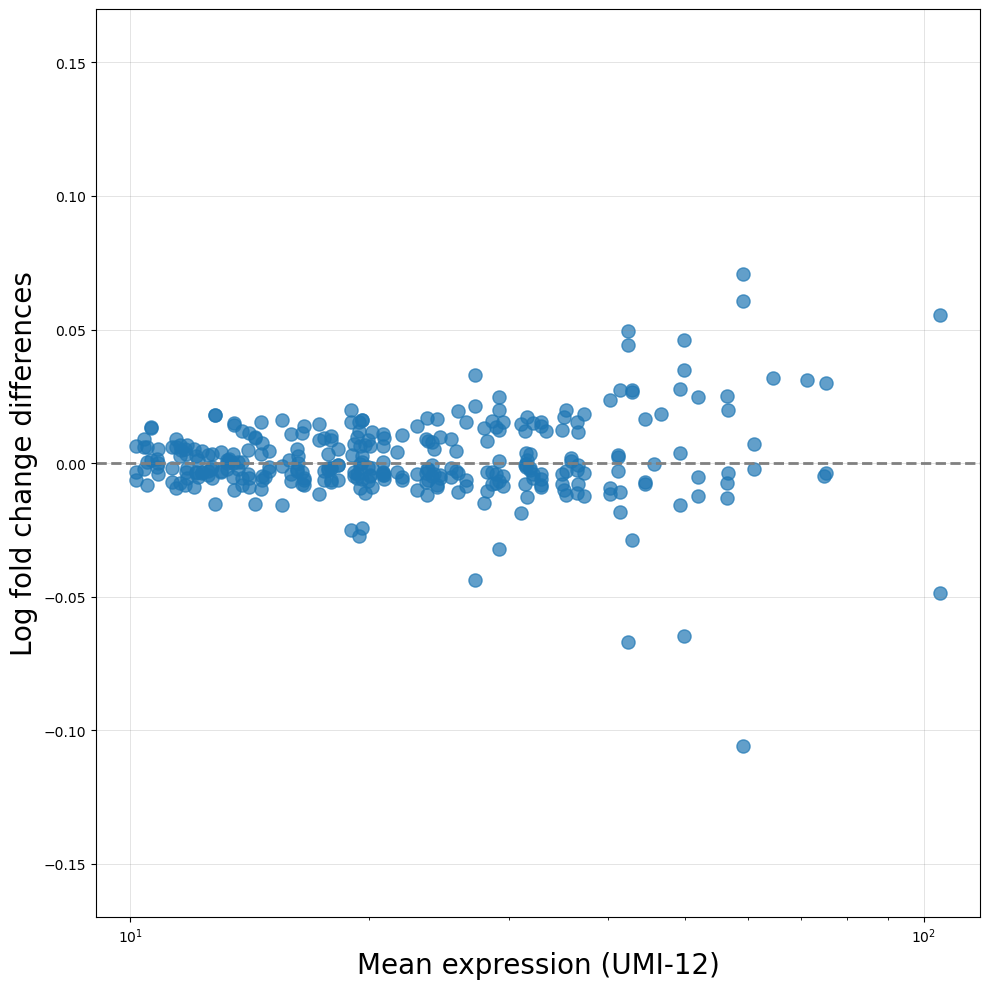

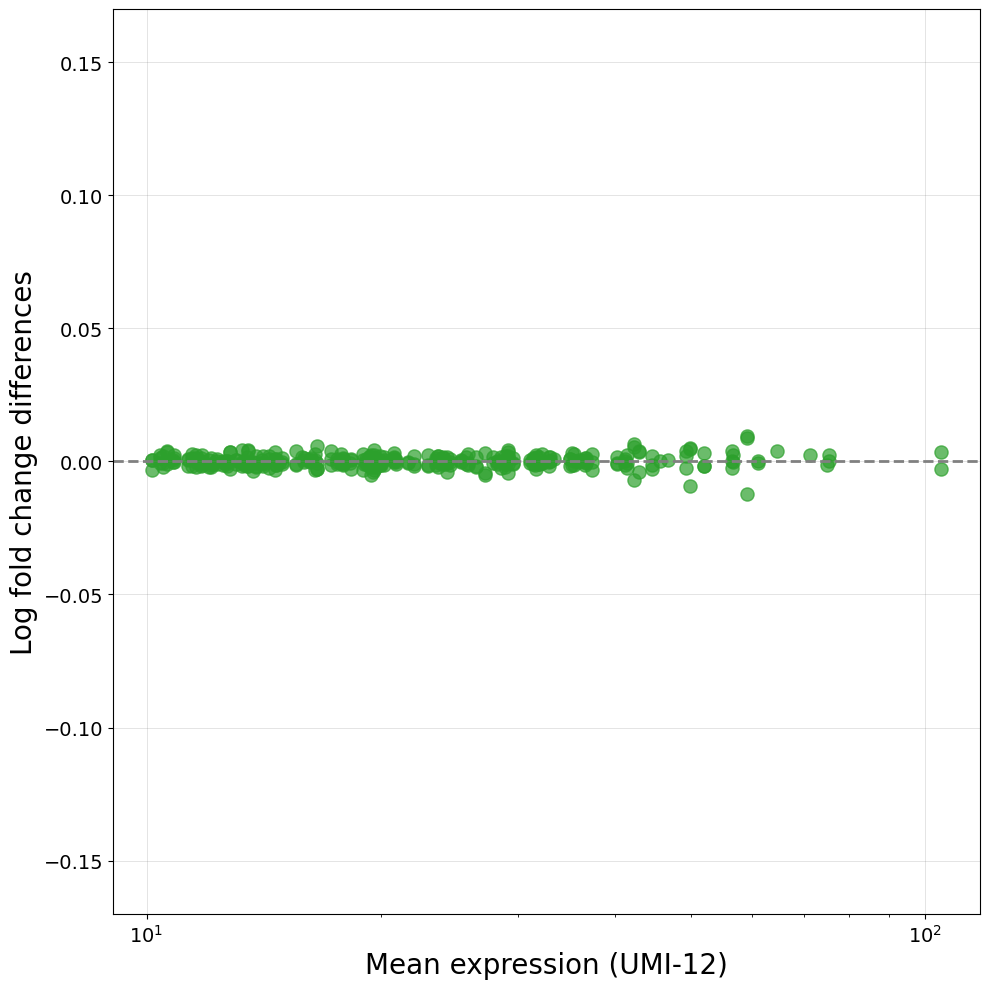

In [19]:
import numpy as np
import pandas as pd
import scanpy as sc
import scipy.sparse as sp
import matplotlib.pyplot as plt
from pathlib import Path


j = 5
dataset = "10k_PBMCs"

if dataset == "10k_PBMCs":
    # Define the cell types of interest for this dataset
    CELLS = ["CD14_mono", "B_naive", "CD4.Naive"]
elif dataset == "10k_PBMCs":
    CELLS = ["CD14_mono", "B_naive", "CD4.Naive", "CD8.Naive"]
elif dataset == "5k_PBMCs":
    CELLS = ["CD14_mono", "NK_16hi", "CD4.Naive", "CD8.Naive"]

METHOD = "wilcoxon"
FC_HI = np.log2(1.25)     # ≈ +0.32
FC_LO = -np.log2(1.25)    # ≈ -0.32
PVAL_THRESH = 0.05
AVG_COUNT_MIN = 10

# I/O
GT_PATH  = f"/data/dagyeman/cellranger/bam_file_analysis/{dataset}/ub_objects/adata_matrices/adata_12.h5ad"
LAB_PATH = f"/data/dagyeman/cellranger/bam_file_analysis/{dataset}/ub_objects/adata_matrices/cell_annotations/annotated_adata_matrices/annotated_adata_12.h5ad"
NAIVE    = f"/data/dagyeman/cellranger/bam_file_analysis/{dataset}/ub_objects/adata_matrices/adata_{j}.h5ad"
PRED     = f"/data/dagyeman/cellranger/bam_file_analysis/{dataset}/ub_objects/col_aware_nunif_matrices/adata_{j}.h5ad"

# Visual style per cell
STYLE_1 = {
    "CD14_mono": {"color": "#1f77b4", "marker": "o", "label": "CD14_mono"},
    "B_naive":   {"color": "#1f77b4", "marker": "o", "label": "B_naive"},
    "CD4.Naive": {"color": "#1f77b4", "marker": "o", "label": "CD4.Naive"},
    "CD8.Naive": {"color": "#1f77b4", "marker": "o", "label": "CD8.Naive"},
    "NK_16hi":  {"color": "#1f77b4", "marker": "o", "label": "NK_16hi"},
}

STYLE_2 = {
    "CD14_mono": {"color": "#2ca02c", "marker": "o", "label": "CD14_mono"},
    "B_naive":   {"color": "#2ca02c", "marker": "o", "label": "B_naive"},
    "CD4.Naive": {"color": "#2ca02c", "marker": "o", "label": "CD4.Naive"},
    "CD8.Naive": {"color": "#2ca02c", "marker": "o", "label": "CD8.Naive"},
    "NK_16hi":  {"color": "#2ca02c", "marker": "o", "label": "NK_16hi"},
}

# Sanity checks up front
for p in [GT_PATH, LAB_PATH, NAIVE, PRED]:
    assert Path(p).exists(), f"Missing file: {p}"

# Load once, reuse
adata_gt    = sc.read_h5ad(GT_PATH)
if "MALAT1" in adata_gt.var_names:   # <<< remove MALAT1
    adata_gt = adata_gt[:, adata_gt.var_names != "MALAT1"].copy()

labels  = sc.read_h5ad(LAB_PATH)

adata_naive = sc.read_h5ad(NAIVE)
if "MALAT1" in adata_naive.var_names:   # <<< remove MALAT1
    adata_naive = adata_naive[:, adata_naive.var_names != "MALAT1"].copy()

adata_pred  = sc.read_h5ad(PRED)
if "MALAT1" in adata_pred.var_names:    # <<< remove MALAT1
    adata_pred = adata_pred[:, adata_pred.var_names != "MALAT1"].copy()

# The big alignment checks
assert adata_gt.obs_names.equals(adata_naive.obs_names), f"Cell barcodes differ at UMI-{j} (naive)."
assert adata_gt.var_names.equals(adata_naive.var_names), f"Genes differ at UMI-{j} (naive)."
assert adata_gt.obs_names.equals(adata_pred.obs_names),  f"Cell barcodes differ at UMI-{j} (pred)."
assert adata_gt.var_names.equals(adata_pred.var_names),  f"Genes differ at UMI-{j} (pred)."

# Normalize the UMI-j matrices
for ad in (adata_naive, adata_pred):
    sc.pp.normalize_total(ad, target_sum=1e4)
    sc.pp.log1p(ad)

# Precompute average counts from the raw GT matrix
X12 = adata_gt.X
avg12 = (np.asarray(X12.mean(axis=0)).ravel() if sp.issparse(X12) else X12.mean(axis=0))
df_avg12 = pd.DataFrame({"gene": adata_gt.var_names, "avg_count": avg12})

rows_naive, rows_pred = [], []
metrics = {}

# Core loop per cell
for cell in CELLS:
    # Binary label: target vs everything else for DE
    reference_labels = labels.obs["majority_voting"].copy()
    binary_labels = reference_labels.apply(lambda x: cell if x == cell else "Other cells")

    # --- GT DE
    adata_12_norm = adata_gt.copy()
    sc.pp.normalize_total(adata_12_norm, target_sum=1e4)
    sc.pp.log1p(adata_12_norm)
    adata_12_norm.obs["label"] = binary_labels.loc[adata_12_norm.obs_names]

    sc.tl.rank_genes_groups(adata_12_norm, groupby="label", method=METHOD, key_added=METHOD, use_raw=False)
    de_12 = sc.get.rank_genes_groups_df(adata_12_norm, group=cell, key=METHOD)

    # Attach avg counts
    de_12_avg = de_12.merge(df_avg12, left_on="names", right_on="gene", how="left").drop(columns="gene")
    pcol = "pvals_adj" if "pvals_adj" in de_12_avg.columns else "pvals"
    keep_genes = de_12_avg.loc[
        ((de_12_avg["logfoldchanges"] >= FC_HI) | (de_12_avg["logfoldchanges"] <= FC_LO))
        & (de_12_avg[pcol] < PVAL_THRESH)
        & (de_12_avg["avg_count"] >= AVG_COUNT_MIN),
        "names"
    ].astype(str).values

    # --- Naive DE and Pred DE at UMI-j
    adata_naive.obs["label"] = binary_labels.loc[adata_naive.obs_names]
    adata_pred.obs["label"]  = binary_labels.loc[adata_pred.obs_names]

    sc.tl.rank_genes_groups(adata_naive, groupby="label", method=METHOD, key_added=METHOD, use_raw=False)
    sc.tl.rank_genes_groups(adata_pred,  groupby="label", method=METHOD, key_added=METHOD, use_raw=False)

    de_naive = sc.get.rank_genes_groups_df(adata_naive, group=cell, key=METHOD)
    de_pred  = sc.get.rank_genes_groups_df(adata_pred,  group=cell, key=METHOD)

    de_naive_avg = de_naive.merge(df_avg12, left_on="names", right_on="gene", how="left").drop(columns="gene")
    de_pred_avg  = de_pred .merge(df_avg12, left_on="names", right_on="gene", how="left").drop(columns="gene")

    # Filter and merge
    de_12_k    = de_12_avg   [de_12_avg["names"].isin(keep_genes)]
    de_naive_k = de_naive_avg[de_naive_avg["names"].isin(keep_genes)]
    de_pred_k  = de_pred_avg [de_pred_avg["names"].isin(keep_genes)]

    df = (
        de_12_k[["names", "logfoldchanges", "avg_count"]]
        .rename(columns={"logfoldchanges": "lfc_12"})
        .merge(de_naive_k[["names", "logfoldchanges"]].rename(columns={"logfoldchanges": "lfc_naive"}),
               on="names", how="left", validate="one_to_one")
        .merge(de_pred_k[["names", "logfoldchanges"]].rename(columns={"logfoldchanges": "lfc_pred"}),
               on="names", how="left", validate="one_to_one")
        .sort_values("avg_count")
        .reset_index(drop=True)
    )

    # Residuals
    df["logrf_naive"] = df["lfc_naive"] - df["lfc_12"]
    df["logrf_pred"]  = df["lfc_pred"]  - df["lfc_12"]

    # Metrics
    se_naive = (df["lfc_naive"].to_numpy() - df["lfc_12"].to_numpy())**2
    se_pred  = (df["lfc_pred" ].to_numpy() - df["lfc_12"].to_numpy())**2

    sse_naive = float(se_naive.sum())  if se_naive.size else np.nan
    sse_pred  = float(se_pred.sum())   if se_pred.size  else np.nan
    mse_naive = float(se_naive.mean()) if se_naive.size else np.nan
    mse_pred  = float(se_pred.mean())  if se_pred.size  else np.nan

    metrics[cell] = {
        "SSE_naive": sse_naive, "MSE_naive": mse_naive,
        "SSE_pred":  sse_pred,  "MSE_pred":  mse_pred,
        "n_genes":   int(df.shape[0])
    }

    # Collect rows
    for avg, v in zip(df["avg_count"], df["logrf_naive"]):
        rows_naive.append({"avg_count": float(avg), "logrf_naive": float(v), "cell": cell})
    for avg, v in zip(df["avg_count"], df["logrf_pred"]):
        rows_pred.append({"avg_count": float(avg), "logrf_pred": float(v), "cell": cell})

# Print metrics
for c, m in metrics.items():
    print(
        f"{c:<10s} | n={m['n_genes']:4d} | "
        f"SSE naive={m['SSE_naive']:.6f}  MSE naive={m['MSE_naive']:.6f} | "
        f"SSE pred={m['SSE_pred']:.6f}    MSE pred={m['MSE_pred']:.6f}"
    )

# DataFrames
plot_naive = pd.DataFrame(rows_naive)
plot_pred  = pd.DataFrame(rows_pred)

# Plot 1: GT vs Naive
plt.figure(figsize=(10, 10))
for cell in CELLS:
    sub = plot_naive[plot_naive["cell"] == cell]
    if sub.empty:
        continue
    style = STYLE_1[cell]
    plt.scatter(sub["avg_count"], sub["logrf_naive"], alpha=0.7, s=90,
                color=style["color"], marker=style["marker"], label=style["label"])

plt.axhline(0, color="grey", linestyle="--", linewidth=2)
plt.xscale("log")
plt.xlabel("Mean expression (UMI-12)", fontsize=20)
plt.ylabel("Log fold change differences", fontsize=20)
plt.ylim(-0.17, 0.17)
plt.grid(True, which="major", linestyle="-", linewidth=0.5, color="gray", alpha=0.3)
plt.tight_layout()
plt.savefig(f"/data/dagyeman/cellranger/bam_file_analysis/figures/{dataset}/{dataset}_ALL_logfc_naive_UMI_{j}.pdf")
plt.show()

# Plot 2: GT vs Pred
plt.figure(figsize=(10, 10))
for cell in CELLS:
    sub = plot_pred[plot_pred["cell"] == cell]
    if sub.empty:
        continue
    style = STYLE_2[cell]
    plt.scatter(sub["avg_count"], sub["logrf_pred"], alpha=0.7, s=90,
                color=style["color"], marker=style["marker"], label=style["label"])

plt.axhline(0, color="grey", linestyle="--", linewidth=2)
plt.xscale("log")
plt.xticks(fontsize=14)
plt.xlabel("Mean expression (UMI-12)", fontsize=20)
plt.ylabel("Log fold change differences", fontsize=20)
plt.yticks(fontsize=14)
plt.ylim(-0.17, 0.17)
plt.grid(True, which="major", linestyle="-", linewidth=0.5, color="gray", alpha=0.3)
plt.tight_layout()
plt.savefig(f"/data/dagyeman/cellranger/bam_file_analysis/figures/{dataset}/{dataset}_ALL_logfc_pred_UMI_{j}.pdf")
plt.show()



### Figure 2F

UMI-1: pooled n=490 | MSE naive=0.643244, MSE pred=0.445439 | SSE naive=315.19, SSE pred=218.265
UMI-2: pooled n=490 | MSE naive=0.192078, MSE pred=0.0249219 | SSE naive=94.1183, SSE pred=12.2117
UMI-3: pooled n=490 | MSE naive=0.0302644, MSE pred=0.000258016 | SSE naive=14.8296, SSE pred=0.126428
UMI-4: pooled n=490 | MSE naive=0.00295484, MSE pred=1.66464e-05 | SSE naive=1.44787, SSE pred=0.00815672
UMI-5: pooled n=490 | MSE naive=0.00023233, MSE pred=3.06172e-06 | SSE naive=0.113842, SSE pred=0.00150024
UMI-6: pooled n=490 | MSE naive=1.80961e-05, MSE pred=9.04766e-07 | SSE naive=0.00886709, SSE pred=0.000443335
UMI-7: pooled n=490 | MSE naive=1.63982e-06, MSE pred=4.63606e-07 | SSE naive=0.00080351, SSE pred=0.000227167
UMI-8: pooled n=490 | MSE naive=4.03408e-07, MSE pred=3.25581e-07 | SSE naive=0.00019767, SSE pred=0.000159535
UMI-9: pooled n=490 | MSE naive=2.53717e-07, MSE pred=2.50613e-07 | SSE naive=0.000124321, SSE pred=0.0001228
UMI-10: pooled n=490 | MSE naive=1.35977e-07,

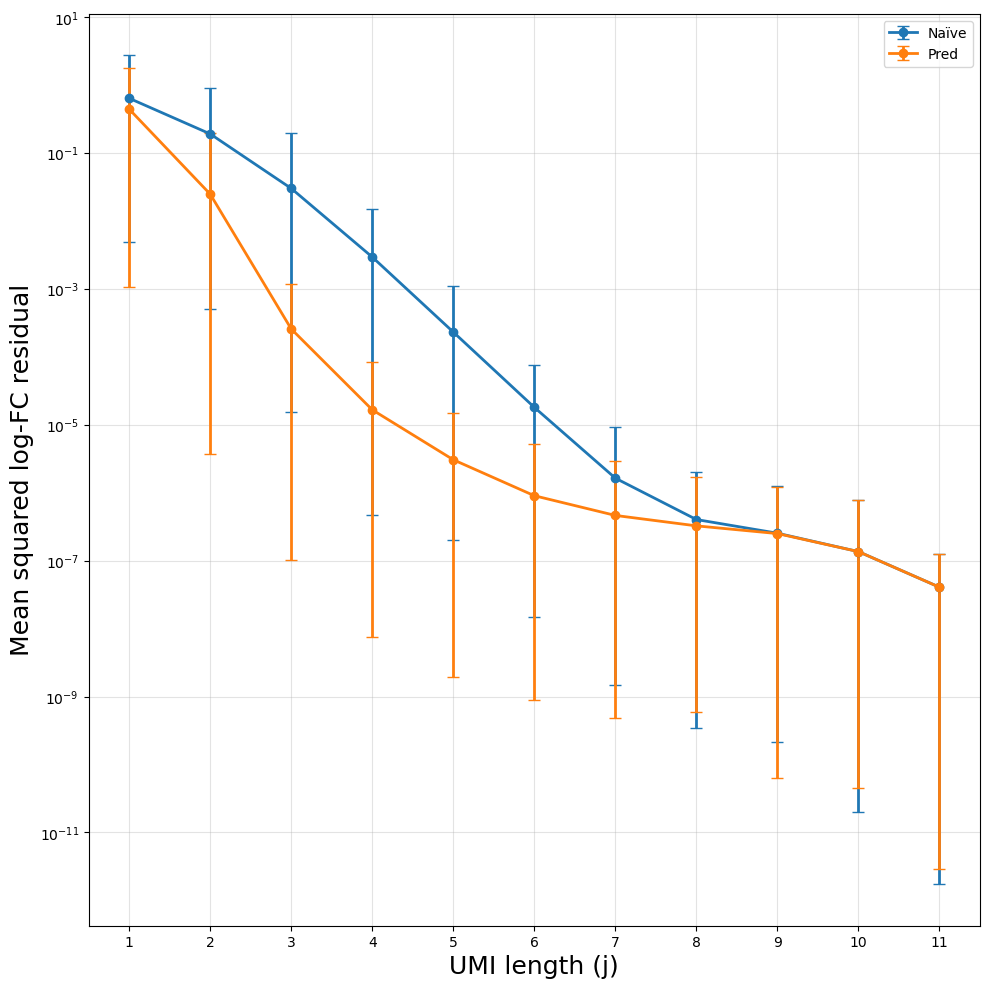

In [26]:
import numpy as np
import pandas as pd
import scanpy as sc
import scipy.sparse as sp
import matplotlib.pyplot as plt
from pathlib import Path

# -------------------------
# Config
# -------------------------
UMI_MIN, UMI_MAX = 1, 12
dataset = "5k_PBMCs"     # flip to "1k_PBMCs" if needed
METHOD = "wilcoxon"
FC_HI = np.log2(1.25)     # ≈ +0.32
FC_LO = -np.log2(1.25)    # ≈ -0.32
PVAL_THRESH = 0.05
AVG_COUNT_MIN = 10

# Cells to include by dataset (pooled together when computing losses)
if dataset == "1k_PBMCs":
    # Define the cell types of interest for this dataset
    CELLS = ["CD14_mono", "B_naive", "CD4.Naive"]
elif dataset == "10k_PBMCs":
    CELLS = ["CD14_mono", "B_naive", "CD4.Naive", "CD8.Naive"]
elif dataset == "5k_PBMCs":
    CELLS = ["CD14_mono", "NK_16hi", "CD4.Naive", "CD8.Naive"]
else:
    raise ValueError(f"Unknown dataset: {dataset}")

# Paths
ROOT = f"/data/dagyeman/cellranger/bam_file_analysis/{dataset}"
GT_PATH  = f"{ROOT}/ub_objects/adata_matrices/adata_12.h5ad"
LAB_PATH = f"{ROOT}/ub_objects/adata_matrices/cell_annotations/annotated_adata_matrices/annotated_adata_12.h5ad"
NAIVE_FMT = f"{ROOT}/ub_objects/adata_matrices/adata"+"_{j}.h5ad"
PRED_FMT  = f"{ROOT}/ub_objects/col_aware_nunif_matrices/adata"+"_{j}.h5ad"

OUT_DIR = f"/data/dagyeman/cellranger/bam_file_analysis/figures/{dataset}"
Path(OUT_DIR).mkdir(parents=True, exist_ok=True)
OUT_PDF = f"{OUT_DIR}/{dataset}_MSE_across_UMIs_ALLGENES.pdf"
OUT_CSV = f"{OUT_DIR}/{dataset}_MSE_across_UMIs_ALLGENES.csv"

# -------------------------
# Load GT + labels once
# -------------------------
for p in [GT_PATH, LAB_PATH]:
    assert Path(p).exists(), f"Missing file: {p}"

adata_gt = sc.read_h5ad(GT_PATH)
# --- ONLY CHANGE (drop MALAT1 from GT) ---
if "MALAT1" in adata_gt.var_names:
    adata_gt = adata_gt[:, adata_gt.var_names != "MALAT1"].copy()

labels = sc.read_h5ad(LAB_PATH)

# avg counts from *raw* GT (no log1p)  (now MALAT1-free)
X12 = adata_gt.X
avg12 = (np.asarray(X12.mean(axis=0)).ravel() if sp.issparse(X12) else X12.mean(axis=0))
df_avg12 = pd.DataFrame({"gene": adata_gt.var_names.astype(str), "avg_count": avg12})

# -------------------------
# Precompute per-cell maps
# -------------------------
keep_genes_by_label = {}
binary_labels_by_label = {}
de12_map_by_label = {}

reference_labels = labels.obs["majority_voting"].copy()

for cell in CELLS:
    # Binary labels for this 'cell type vs others'
    binary_labels = reference_labels.apply(lambda x: cell if x == cell else "Other cells")
    binary_labels_by_label[cell] = binary_labels  # store for reuse

    # Normalized/log1p GT copy for DE
    adata_12_norm = adata_gt.copy()
    sc.pp.normalize_total(adata_12_norm, target_sum=1e4)
    sc.pp.log1p(adata_12_norm)
    adata_12_norm.obs["label"] = binary_labels.loc[adata_12_norm.obs_names]

    sc.tl.rank_genes_groups(
        adata_12_norm, groupby="label", method=METHOD, key_added=METHOD, use_raw=False
    )
    de_12 = sc.get.rank_genes_groups_df(adata_12_norm, group=cell, key=METHOD)

    # attach avg and filter by GT only
    de_12_avg = de_12.merge(df_avg12, left_on="names", right_on="gene", how="left").drop(columns="gene")
    pcol = "pvals_adj" if "pvals_adj" in de_12_avg.columns else "pvals"

    keep_genes = (
        de_12_avg.loc[
            ((de_12_avg["logfoldchanges"] >= FC_HI) | (de_12_avg["logfoldchanges"] <= FC_LO)) &
            (de_12_avg[pcol] < PVAL_THRESH) &
            (de_12_avg["avg_count"] >= AVG_COUNT_MIN),
            "names"
        ]
        .astype(str)
        .values
    )

    keep_genes_by_label[cell] = set(keep_genes)

    # Keep a compact (gene -> lfc_12) map for this label
    de12_map = de_12[["names", "logfoldchanges"]].rename(columns={"logfoldchanges": "lfc_12"})
    de12_map["names"] = de12_map["names"].astype(str)
    de12_map_by_label[cell] = de12_map

# -------------------------
# Sweep UMI lengths and pool losses across ALL selected genes
# -------------------------
ks = []
mse_naive, mse_pred = [], []
ci_lo_naive, ci_hi_naive = [], []
ci_lo_pred,  ci_hi_pred  = [], []
sse_naive, sse_pred = [], []
n_points = []

for j in range(UMI_MIN, UMI_MAX + 1):
    naive_path = NAIVE_FMT.format(j=j)
    pred_path  = PRED_FMT.format(j=j)
    if not (Path(naive_path).exists() and Path(pred_path).exists()):
        print(f"Skipping UMI-{j}: missing file(s).")
        continue

    adata_naive = sc.read_h5ad(naive_path)
    # --- ONLY CHANGE (drop MALAT1 from naive) ---
    if "MALAT1" in adata_naive.var_names:
        adata_naive = adata_naive[:, adata_naive.var_names != "MALAT1"].copy()

    adata_pred  = sc.read_h5ad(pred_path)
    # --- ONLY CHANGE (drop MALAT1 from pred) ---
    if "MALAT1" in adata_pred.var_names:
        adata_pred = adata_pred[:, adata_pred.var_names != "MALAT1"].copy()

    # Alignment checks
    assert adata_gt.obs_names.equals(adata_naive.obs_names), f"Cell barcodes differ at UMI-{j} (naive)."
    assert adata_gt.var_names.equals(adata_naive.var_names), f"Genes differ at UMI-{j} (naive)."
    assert adata_gt.obs_names.equals(adata_pred.obs_names),  f"Cell barcodes differ at UMI-{j} (pred)."
    assert adata_gt.var_names.equals(adata_pred.var_names),  f"Genes differ at UMI-{j} (pred)."

    # Normalize/log1p once per matrix
    for ad in (adata_naive, adata_pred):
        sc.pp.normalize_total(ad, target_sum=1e4)
        sc.pp.log1p(ad)

    # Accumulators across ALL genes at this j
    se_naive_all = []
    se_pred_all  = []

    # Per cell: run DE at UMI-j, restrict to that cell's GT keep set, merge with its GT lfc_12, accumulate SEs
    for cell in CELLS:
        # set labels for this cell
        adata_naive.obs["label"] = binary_labels_by_label[cell].loc[adata_naive.obs_names]
        adata_pred .obs["label"] = binary_labels_by_label[cell].loc[adata_pred.obs_names]

        # DE at UMI-j
        sc.tl.rank_genes_groups(adata_naive, groupby="label", method=METHOD, key_added=METHOD, use_raw=False)
        sc.tl.rank_genes_groups(adata_pred,  groupby="label", method=METHOD, key_added=METHOD, use_raw=False)

        de_naive = sc.get.rank_genes_groups_df(adata_naive, group=cell, key=METHOD).copy()
        de_pred  = sc.get.rank_genes_groups_df(adata_pred,  group=cell, key=METHOD).copy()

        # Restrict to this label's GT keep set
        keep = keep_genes_by_label[cell]
        if not keep:
            continue

        de_naive = de_naive[de_naive["names"].astype(str).isin(keep)]
        de_pred  = de_pred [de_pred ["names"].astype(str).isin(keep)]

        # Merge with GT lfc_12 for this label; keep only genes present in all
        de12_map = de12_map_by_label[cell]
        df = (
            de12_map.merge(
                de_naive[["names", "logfoldchanges"]].rename(columns={"logfoldchanges": "lfc_naive"}),
                on="names", how="inner"
            ).merge(
                de_pred[["names", "logfoldchanges"]].rename(columns={"logfoldchanges": "lfc_pred"}),
                on="names", how="inner"
            )
        )

        if df.empty:
            continue

        # Squared residuals wrt GT
        se_naive = (df["lfc_naive"].to_numpy() - df["lfc_12"].to_numpy()) ** 2
        se_pred_ = (df["lfc_pred" ].to_numpy() - df["lfc_12"].to_numpy()) ** 2

        se_naive_all.append(se_naive)
        se_pred_all.append(se_pred_)

    # Pool across ALL genes for this j
    if len(se_naive_all) == 0:
        print(f"UMI-{j}: no overlapping keep genes across labels; skipping.")
        continue

    se_naive_all = np.concatenate(se_naive_all)
    se_pred_all  = np.concatenate(se_pred_all)

    # MSE and empirical 95% intervals
    mse_n = float(se_naive_all.mean())
    mse_p = float(se_pred_all.mean())

    qn_low, qn_high = np.percentile(se_naive_all, [2.5, 97.5])
    qp_low, qp_high = np.percentile(se_pred_all,  [2.5, 97.5])

    # Store absolute CI bounds (not deltas) for CSV; for plotting we’ll convert to asymmetric yerr
    ci_lo_naive.append(qn_low); ci_hi_naive.append(qn_high)
    ci_lo_pred.append(qp_low);  ci_hi_pred.append(qp_high)

    # SSE (optional)
    sse_n = float(se_naive_all.sum())
    sse_p = float(se_pred_all.sum())

    # Collect
    ks.append(j)
    mse_naive.append(mse_n); mse_pred.append(mse_p)
    sse_naive.append(sse_n); sse_pred.append(sse_p)
    n_points.append(int(se_naive_all.size))  # same size as se_pred_all by construction

    print(f"UMI-{j}: pooled n={se_naive_all.size} | MSE naive={mse_n:.6g}, MSE pred={mse_p:.6g} | SSE naive={sse_n:.6g}, SSE pred={sse_p:.6g}")

# -------------------------
# Plot with asymmetric empirical CIs as error bars
# -------------------------
# Convert CI bounds to asymmetric yerr around the mean
yerr_naive = np.vstack([
    np.array(mse_naive) - np.array(ci_lo_naive),
    np.array(ci_hi_naive) - np.array(mse_naive),
])
yerr_pred = np.vstack([
    np.array(mse_pred) - np.array(ci_lo_pred),
    np.array(ci_hi_pred) - np.array(mse_pred),
])

# --- PLOT-TRIM CHANGE: keep computed j=12 but plot only up to j=11 ---
plot_idx = [i for i, k in enumerate(ks) if k <= 11]
plot_ks = [ks[i] for i in plot_idx]
plot_mse_naive = [mse_naive[i] for i in plot_idx]
plot_mse_pred  = [mse_pred[i]  for i in plot_idx]
plot_yerr_naive = yerr_naive[:, plot_idx]
plot_yerr_pred  = yerr_pred[:,  plot_idx]
# ---------------------------------------------------------------

plt.figure(figsize=(10, 10))
plt.errorbar(plot_ks, plot_mse_naive, yerr=plot_yerr_naive, fmt="-o", capsize=4, linewidth=2, label="Naïve")
plt.errorbar(plot_ks, plot_mse_pred,  yerr=plot_yerr_pred,  fmt="-o", capsize=4, linewidth=2, label="Pred")

plt.xticks(range(UMI_MIN, 11 + 1))  # show only 1..11 on the axis
plt.xlabel("UMI length (j)", fontsize=18)
plt.yscale("log")
plt.ylabel("Mean squared log-FC residual", fontsize=18)
# plt.title(f"{dataset}: Pooled DE residuals across {len(CELLS)} labels", fontsize=16)
plt.grid(True, linestyle="-", alpha=0.35)
plt.legend()
plt.tight_layout()
# plt.savefig(OUT_PDF)
plt.show()
# print(f"Saved: {OUT_PDF}")




/tmp/ipykernel_1785112/2222750154.py:33: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0)


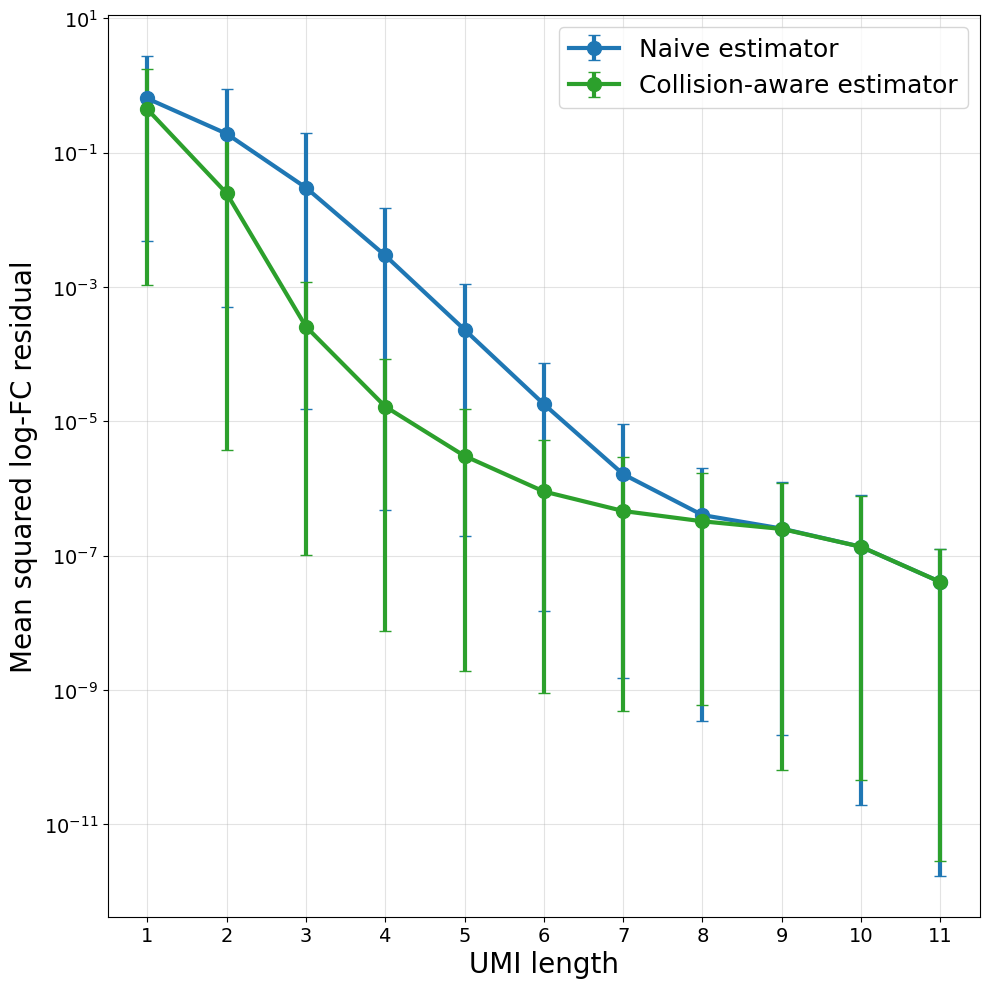

In [27]:
# Trim out UMI=12 before plotting
plot_idx = [i for i, k in enumerate(ks) if k <= 11]

plot_ks = [ks[i] for i in plot_idx]
plot_mse_naive = [mse_naive[i] for i in plot_idx]
plot_mse_pred  = [mse_pred[i]  for i in plot_idx]

plot_yerr_naive = np.vstack([
    np.array(plot_mse_naive) - np.array([ci_lo_naive[i] for i in plot_idx]),
    np.array([ci_hi_naive[i] for i in plot_idx]) - np.array(plot_mse_naive),
])
plot_yerr_pred = np.vstack([
    np.array(plot_mse_pred) - np.array([ci_lo_pred[i] for i in plot_idx]),
    np.array([ci_hi_pred[i] for i in plot_idx]) - np.array(plot_mse_pred),
])

plt.figure(figsize=(10, 10))
plt.errorbar(
    plot_ks, plot_mse_naive, yerr=plot_yerr_naive, fmt="-o",
    color="#1f77b4", markerfacecolor="#1f77b4", markeredgecolor="#1f77b4",
    capsize=4, markersize=10, linewidth=3, label="Naive estimator"
)
plt.errorbar(
    plot_ks, plot_mse_pred, yerr=plot_yerr_pred, fmt="-o",
    color="#2ca02c", markerfacecolor="#2ca02c", markeredgecolor="#2ca02c",
    capsize=4, markersize=10, linewidth=3, label="Collision-aware estimator"
)

plt.xticks(range(UMI_MIN, 11 + 1), fontsize=14)  # only 1..11
plt.yticks(fontsize=14)
plt.xlabel("UMI length", fontsize=20)
plt.yscale("log")
plt.ylim(0)
plt.ylabel("Mean squared log-FC residual", fontsize=20)
plt.grid(True, linestyle="-", alpha=0.35)
plt.legend(fontsize=18)
plt.tight_layout()
plt.savefig(OUT_PDF)
plt.show()
# print(f"Saved: {OUT_PDF}")


## Figure S8

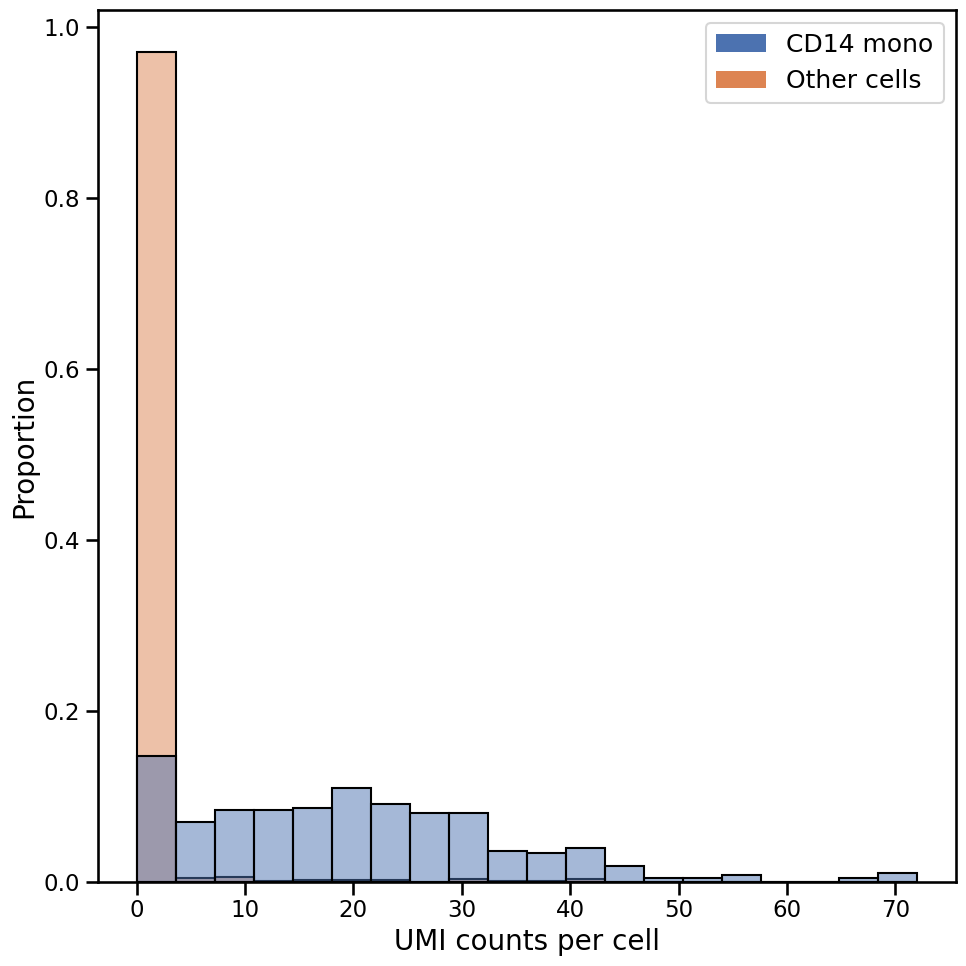

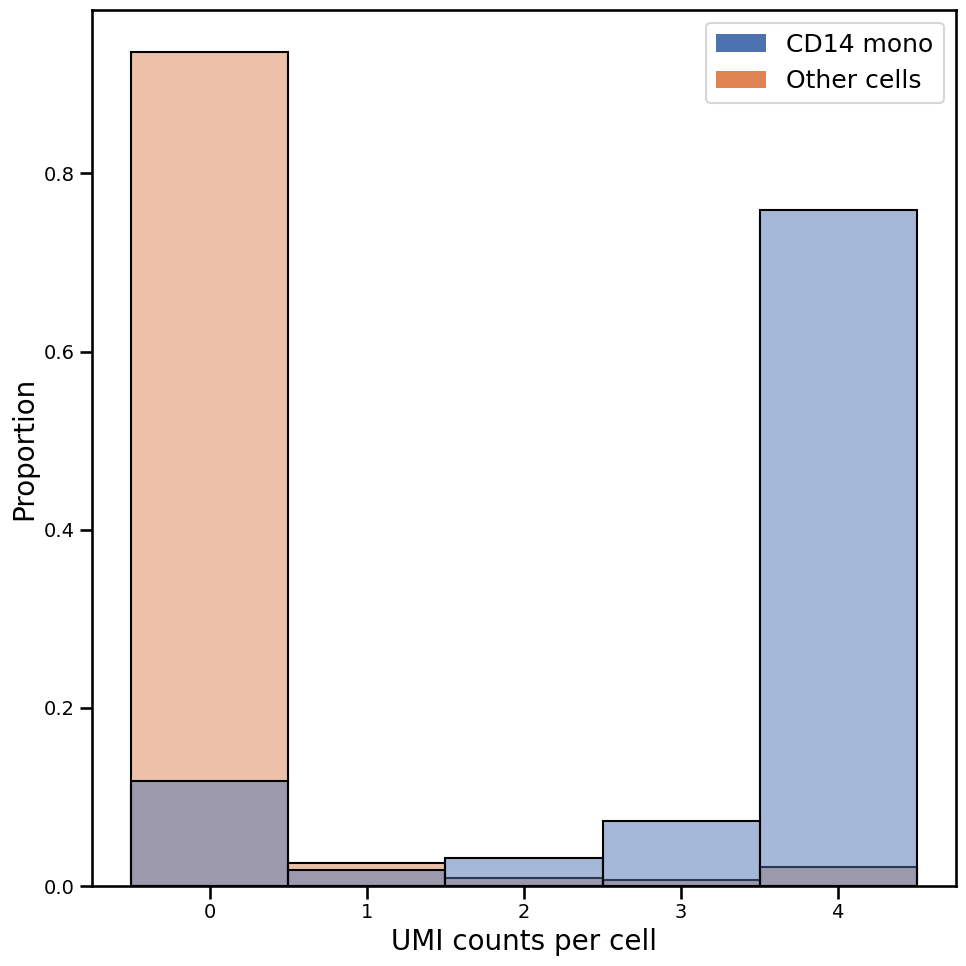

In [71]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch

dataset = "1k_PBMCs"  # Change to "10k_PBMCs" if needed

sns.set_context("talk")

j = 1  # naive UMI length

# Load cell annotation labels
labels = sc.read_h5ad(f"/data/dagyeman/cellranger/bam_file_analysis/{dataset}/ub_objects/adata_matrices/cell_annotations/annotated_adata_matrices/annotated_adata_12.h5ad")
reference_labels = labels.obs['majority_voting'].copy()
binary_labels = reference_labels.apply(lambda x: 'CD14_mono' if x == 'CD14_mono' else 'Other cells')

# Load datasets
adata_12   = sc.read_h5ad(f"/data/dagyeman/cellranger/bam_file_analysis/{dataset}/ub_objects/adata_matrices/adata_12.h5ad")
adata_naive = sc.read_h5ad(f"/data/dagyeman/cellranger/bam_file_analysis/{dataset}/ub_objects/adata_matrices/adata_{j}.h5ad")

adata_12.obs['label'] = binary_labels

gene = "FCN1"
g_idx = adata_12.var_names.get_loc(gene)
is_cd14 = (adata_12.obs["label"] == "CD14_mono").values  # boolean array aligned to obs

def dense_col(X, idx):
    col = X[:, idx]
    return col.toarray().ravel() if not isinstance(col, np.ndarray) else col.ravel()

# Use a fixed palette so our manual legend colors match the bars
_palette = sns.color_palette("deep", n_colors=2)
palette_map = {"CD14_mono": _palette[0], "Other cells": _palette[1]}

# -------- Panel A: Ground truth UMI-12 (PMF, shared bins) --------
vals_gt = dense_col(adata_12.X, g_idx)
vals_gt_cd14  = vals_gt[is_cd14]
vals_gt_other = vals_gt[~is_cd14]

# Shared bins computed from combined data
edges_A = np.histogram_bin_edges(np.concatenate([vals_gt_cd14, vals_gt_other]), bins=20)

dfA = pd.DataFrame({
    "counts": np.concatenate([vals_gt_cd14, vals_gt_other]),
    "group":  (["CD14_mono"] * len(vals_gt_cd14)) + (["Other cells"] * len(vals_gt_other))
})

plt.figure(figsize=(10,10))
sns.histplot(
    data=dfA, x="counts", hue="group",
    bins=edges_A, stat="probability", common_norm=False, multiple="layer",
    hue_order=["CD14_mono", "Other cells"], palette=palette_map, legend=False
)
plt.xlabel("UMI counts per cell", fontsize=20)
plt.ylabel("Proportion", fontsize=20)

# Hard-coded legend
ax = plt.gca()
handles = [
    Patch(facecolor=palette_map["CD14_mono"], label="CD14 mono"),
    Patch(facecolor=palette_map["Other cells"], label="Other cells")
]
ax.legend(handles=handles, fontsize=18)

plt.tight_layout()
plt.savefig(f"/data/dagyeman/cellranger/bam_file_analysis/figures/1k_PBMCs/{gene}_gt_UMI_12_pmf.pdf")
plt.show()

# -------- Panel B: Naive UMI-1 (integer bins, integer ticks) --------
vals_nv = dense_col(adata_naive.X, g_idx)
vals_nv_cd14  = vals_nv[is_cd14]
vals_nv_other = vals_nv[~is_cd14]

# Integer-centered bins: [-0.5, 0.5], [0.5, 1.5], etc.
max_val = int(np.max(np.concatenate([vals_nv_cd14, vals_nv_other])))
edges_B = np.arange(-0.5, max_val + 1.5, 1)

dfB = pd.DataFrame({
    "counts": np.concatenate([vals_nv_cd14, vals_nv_other]),
    "group":  (["CD14_mono"] * len(vals_nv_cd14)) + (["Other cells"] * len(vals_nv_other))
})

plt.figure(figsize=(10,10))
sns.histplot(
    data=dfB, x="counts", hue="group",
    bins=edges_B, stat="probability", common_norm=False, multiple="layer",
    hue_order=["CD14_mono", "Other cells"], palette=palette_map, legend=False
)
plt.xlabel("UMI counts per cell", fontsize=20)
plt.ylabel("Proportion", fontsize=20)
plt.xticks(np.arange(0, max_val + 1, 1), fontsize=14)
plt.yticks(fontsize=14)

# Hard-coded legend
ax = plt.gca()
handles = [
    Patch(facecolor=palette_map["CD14_mono"], label="CD14 mono"),
    Patch(facecolor=palette_map["Other cells"], label="Other cells")
]
ax.legend(handles=handles, fontsize=18)

plt.tight_layout()
plt.savefig(f"/data/dagyeman/cellranger/bam_file_analysis/figures/{dataset}/{gene}__naive_UMI_{j}_pmf.pdf")

### Same plot as above but with UMI 0 

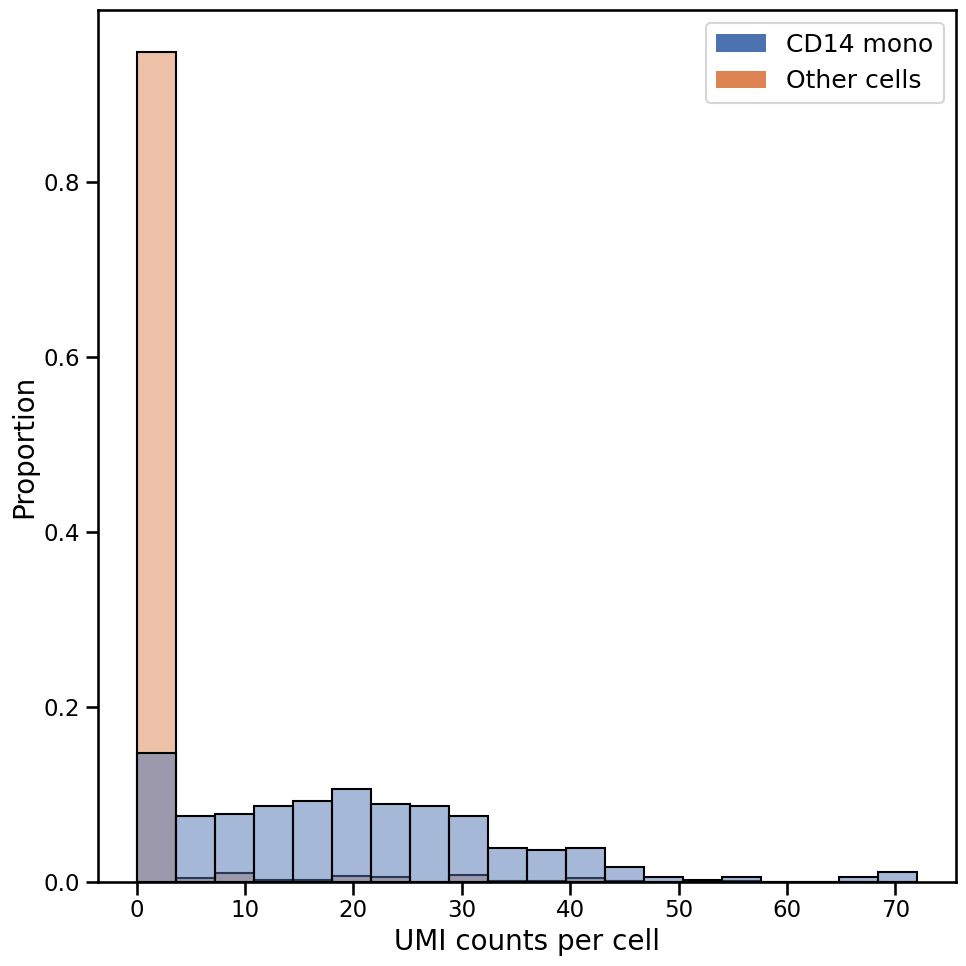

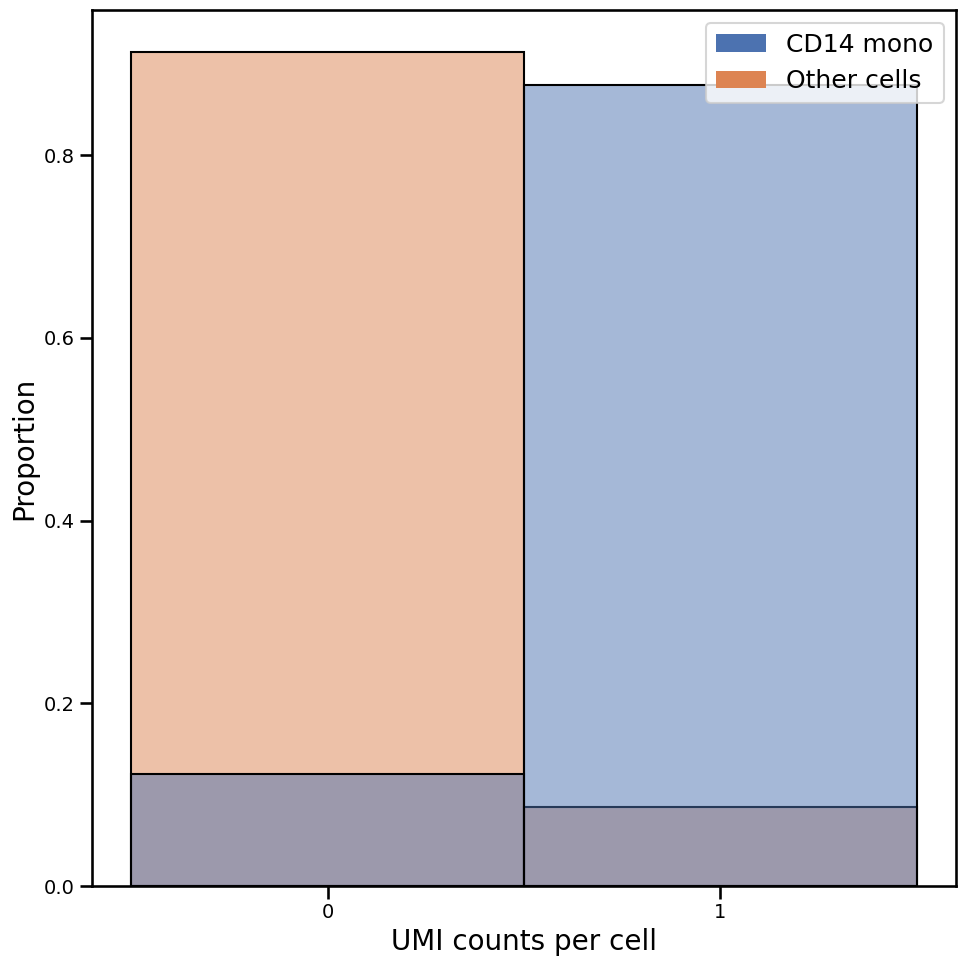

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch

dataset = "1k_PBMCs"  # Change to "10k_PBMCs" if needed

sns.set_context("talk")

j = 1  # naive UMI length

# Load cell annotation labels
labels = sc.read_h5ad(f"/data/dagyeman/cellranger/bam_file_analysis/{dataset}/ub_objects/adata_matrices/cell_annotations/annotated_adata_matrices/annotated_adata_12.h5ad")
reference_labels = labels.obs['majority_voting'].copy()
binary_labels = reference_labels.apply(lambda x: 'CD14_mono' if x == 'CD14_mono' else 'Other cells')

# Load datasets
adata_12   = sc.read_h5ad(f"/data/dagyeman/cellranger/bam_file_analysis/{dataset}/ub_objects/adata_matrices/adata_12.h5ad")
adata_naive = sc.read_h5ad(f"/data/dagyeman/cellranger/bam_file_analysis/{dataset}/ub_objects/adata_matrices/adata_{j}.h5ad")

adata_12.obs['label'] = binary_labels

gene = "FCN1"
g_idx = adata_12.var_names.get_loc(gene)
is_cd14 = (adata_12.obs["label"] == "CD14_mono").values  # boolean array aligned to obs

def dense_col(X, idx):
    col = X[:, idx]
    return col.toarray().ravel() if not isinstance(col, np.ndarray) else col.ravel()

# Use a fixed palette so our manual legend colors match the bars
_palette = sns.color_palette("deep", n_colors=2)
palette_map = {"CD14_mono": _palette[0], "Other cells": _palette[1]}

# -------- Panel A: Ground truth UMI-12 (PMF, shared bins) --------
vals_gt = dense_col(adata_12.X, g_idx)
vals_gt_cd14  = vals_gt[is_cd14]
vals_gt_other = vals_gt[~is_cd14]

edges_A = np.histogram_bin_edges(np.concatenate([vals_gt_cd14, vals_gt_other]), bins=20)

dfA = pd.DataFrame({
    "counts": np.concatenate([vals_gt_cd14, vals_gt_other]),
    "group":  (["CD14_mono"] * len(vals_gt_cd14)) + (["Other cells"] * len(vals_gt_other))
})

plt.figure(figsize=(10,10))
sns.histplot(
    data=dfA, x="counts", hue="group",
    bins=edges_A, stat="probability", common_norm=False, multiple="layer",
    hue_order=["CD14_mono", "Other cells"], palette=palette_map, legend=False
)
plt.xlabel("UMI counts per cell", fontsize=20)
plt.ylabel("Proportion", fontsize=20)

ax = plt.gca()
handles = [
    Patch(facecolor=palette_map["CD14_mono"], label="CD14 mono"),
    Patch(facecolor=palette_map["Other cells"], label="Other cells")
]
ax.legend(handles=handles, fontsize=18)

plt.tight_layout()
plt.savefig(f"/data/dagyeman/cellranger/bam_file_analysis/figures/1k_PBMCs/{gene}_gt_UMI_12_pmf.pdf")
plt.show()

# -------- Panel B: UMI-0 (binary presence/absence) --------
vals_nv = dense_col(adata_naive.X, g_idx)
# Collapse counts > 0 to 1
vals_nv = (vals_nv > 0).astype(int)
vals_nv_cd14  = vals_nv[is_cd14]
vals_nv_other = vals_nv[~is_cd14]

edges_B = [-0.5, 0.5, 1.5]  # only two bins: 0 and 1

dfB = pd.DataFrame({
    "counts": np.concatenate([vals_nv_cd14, vals_nv_other]),
    "group":  (["CD14_mono"] * len(vals_nv_cd14)) + (["Other cells"] * len(vals_nv_other))
})

plt.figure(figsize=(10,10))
sns.histplot(
    data=dfB, x="counts", hue="group",
    bins=edges_B, stat="probability", common_norm=False, multiple="layer",
    hue_order=["CD14_mono", "Other cells"], palette=palette_map, legend=False
)
plt.xlabel("UMI counts per cell", fontsize=20)
plt.ylabel("Proportion", fontsize=20)
plt.xticks([0,1], fontsize=14)
plt.yticks(fontsize=14)

ax = plt.gca()
handles = [
    Patch(facecolor=palette_map["CD14_mono"], label="CD14 mono"),
    Patch(facecolor=palette_map["Other cells"], label="Other cells")
]
ax.legend(handles=handles, fontsize=18)

plt.tight_layout()
# plt.savefig(f"/data/dagyeman/cellranger/bam_file_analysis/figures/{dataset}/{gene}__UMI_0_pmf.pdf")
plt.show()


## Figure XX: CellTypist Error plot
- make sure the annotations were done without MALAT1

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0.37743506 0.18993506 0.13636364 0.09253247 0.08847403 0.08116883
 0.06574675 0.09902597 0.09983766 0.06006494 0.03084416 0.        ]
[0.33847403 0.1525974  0.10308442 0.08766234 0.07548701 0.05113636
 0.06006494 0.06006494 0.05275974 0.03733766 0.03084416 0.04545455]
0.9074675324675324


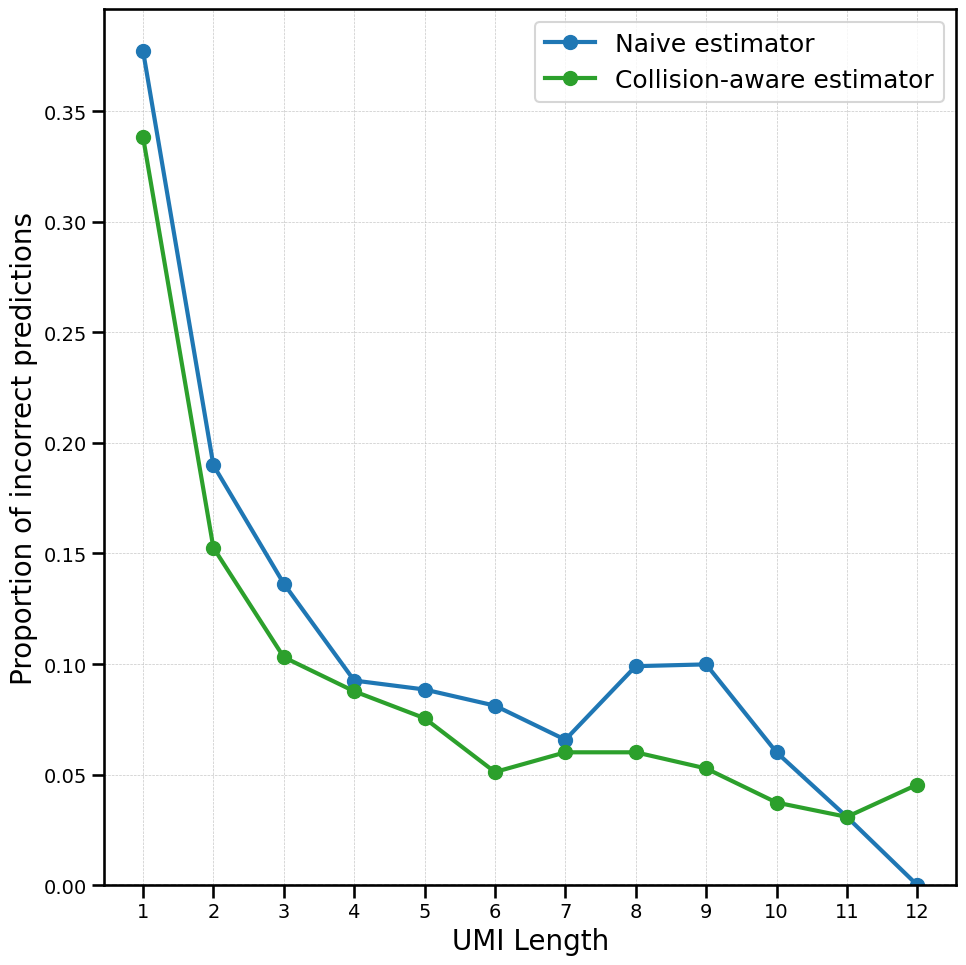

In [8]:
import os
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
dataset = "1k_PBMCs"  # Change to "10k_PBMCs" if needed
# Paths
regular_path = f"/data/dagyeman/cellranger/bam_file_analysis/{dataset}/ub_objects/adata_matrices/cell_annotations/annotated_adata_matrices"
inverted_path = f"/data/dagyeman/cellranger/bam_file_analysis/{dataset}/ub_objects/col_aware_nunif_matrices/cell_annotations/annotated_inv_matrices"

# regular_path = "/data/dagyeman/cellranger/bam_file_analysis/10k_PBMCs/ur_objects/adata_matrices/cell_annotations/annotated_adata_matrices"
# inverted_path = "/data/dagyeman/cellranger/bam_file_analysis/10k_PBMCs/ur_objects/inverted2_adata_matrices/cell_annotations/annotated_inv_matrices"

# 1) Load regular annotated adata matrices into a dict
annotated_ads_reg = {
    i: sc.read_h5ad(f"{regular_path}/annotated_adata_{i}.h5ad")
    for i in range(1, 13)
}

# 2) Use UMI 12 as ground truth
ground_truth_adata = annotated_ads_reg[12]
common_cells = sorted(ground_truth_adata.obs_names)
ground_truth = ground_truth_adata.obs.loc[common_cells, 'majority_voting'].astype(str).values
gt_labels = ground_truth_adata.obs['majority_voting'].astype(str).to_dict()

# 4) Compute error vectors
error_vector_reg = np.zeros(12)
error_vector_inv = np.zeros(12)
print(error_vector_reg)
print(error_vector_inv)

for i in range(1, 13):
    # Regular predictions aligned to UMI-12 cells
    ad_reg = annotated_ads_reg[i]
    present = [c for c in common_cells if c in ad_reg.obs_names]
    preds_reg = ad_reg.obs.loc[present, 'majority_voting'].astype(str).values
    true_aligned = np.array([gt_labels[c] for c in present], dtype=str)
    error_vector_reg[i - 1] = np.mean(preds_reg != true_aligned)

    # Inverted predictions aligned to UMI-12 cells
    ad_inv = sc.read_h5ad(f"{inverted_path}/annotated_adata_{i}.h5ad")
    present_inv = [c for c in common_cells if c in ad_inv.obs_names]
    preds_inv = ad_inv.obs.loc[present_inv, 'majority_voting'].astype(str).values
    true_aligned_inv = np.array([gt_labels[c] for c in present_inv], dtype=str)
    error_vector_inv[i - 1] = np.mean(preds_inv != true_aligned_inv)

print(error_vector_reg)
print(error_vector_inv)
print(1 - error_vector_reg[3])

# 5) Plot both error curves
plt.figure(figsize=(10, 10))

# Blue for Naive (Regular)
plt.plot(
    range(1, 13), error_vector_reg, marker='o', linestyle='-',
    label='Naive estimator', markersize=10, linewidth=3, color='#1f77b4'
)

# Green for Collision-aware (Inverted)
plt.plot(
    range(1, 13), error_vector_inv, marker='o', linestyle='-',
    label='Collision-aware estimator', markersize=10, linewidth=3, color='#2ca02c'
)

plt.xlabel('UMI Length', fontsize=20)
plt.ylabel('Proportion of incorrect predictions', fontsize=20)
plt.ylim(bottom=0)
plt.xticks(range(1, 13), fontsize=14)
plt.yticks(fontsize=14)
plt.axhline(y=0, color='k', linestyle='--', linewidth=1)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
# plt.title('Error in Cell Type Predictions (All Genes, No MALAT1)', fontsize=24)
plt.legend(fontsize=18)
plt.tight_layout()
out_file = f"/data/dagyeman/cellranger/bam_file_analysis/figures/{dataset}/{dataset}_cell_typist_error.pdf"
# os.makedirs(os.path.dirname(out_file), exist_ok=True)
plt.savefig(out_file)
plt.show()


## Figure S9

CD14_mono  | n=5058 | SSE naive=0.698276  MSE naive=0.000138 | SSE pred=0.474774    MSE pred=0.000094
B_naive    | n=2399 | SSE naive=0.378486  MSE naive=0.000158 | SSE pred=0.187164    MSE pred=0.000078
CD4.Naive  | n=3071 | SSE naive=0.459984  MSE naive=0.000150 | SSE pred=0.331138    MSE pred=0.000108


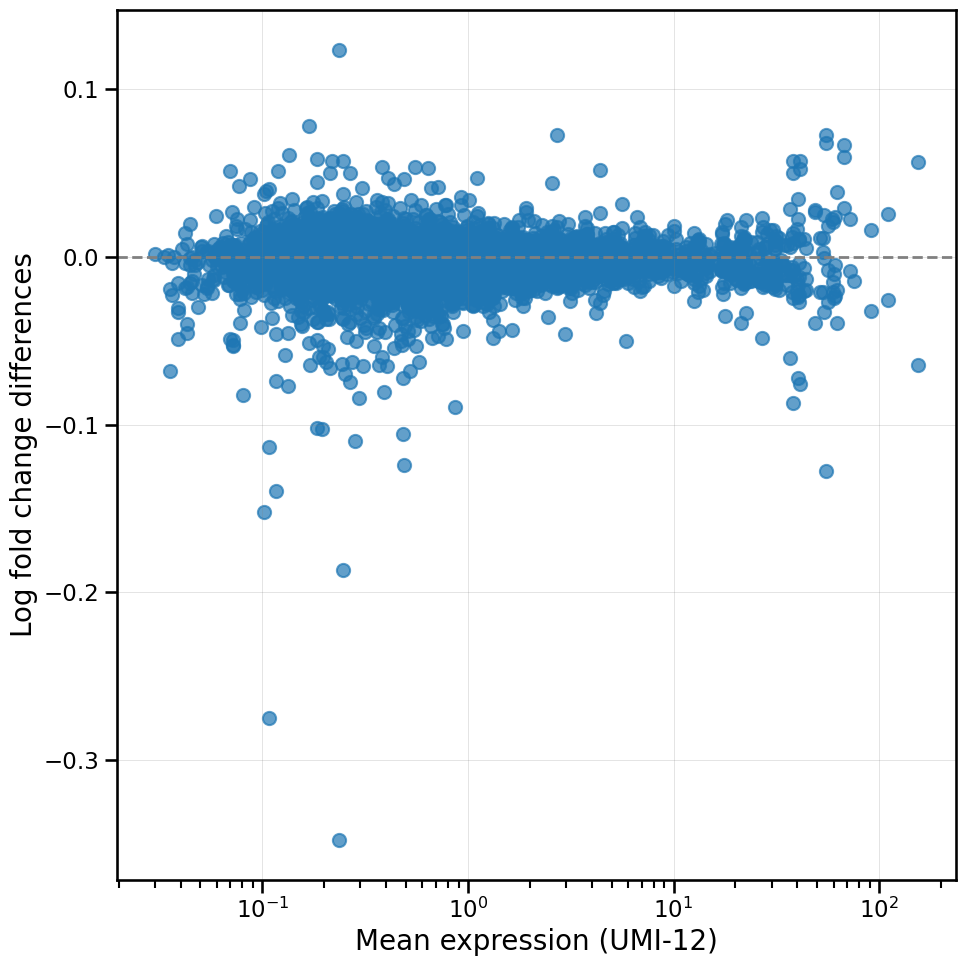

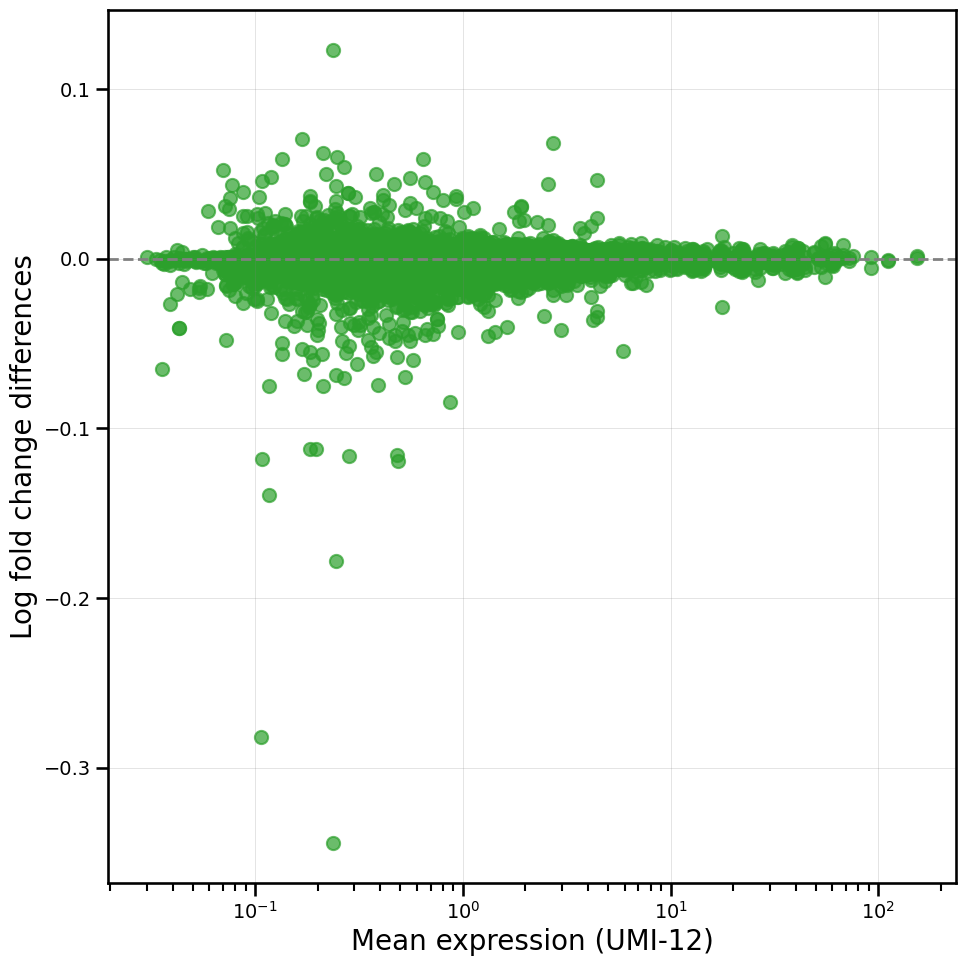

In [73]:
import numpy as np
import pandas as pd
import scanpy as sc
import scipy.sparse as sp
import matplotlib.pyplot as plt
from pathlib import Path


j = 5
dataset = "1k_PBMCs"

if dataset == "1k_PBMCs":
    # Define the cell types of interest for this dataset
    CELLS = ["CD14_mono", "B_naive", "CD4.Naive"]
elif dataset == "10k_PBMCs":
    CELLS = ["CD14_mono", "B_naive", "CD4.Naive", "CD8.Naive"]

METHOD = "wilcoxon"
FC_HI = np.log2(1.25)     # ≈ +0.32
FC_LO = -np.log2(1.25)    # ≈ -0.32
PVAL_THRESH = 0.05
AVG_COUNT_MIN = 0

# I/O
GT_PATH  = f"/data/dagyeman/cellranger/bam_file_analysis/{dataset}/ub_objects/adata_matrices/adata_12.h5ad"
LAB_PATH = f"/data/dagyeman/cellranger/bam_file_analysis/{dataset}/ub_objects/adata_matrices/cell_annotations/annotated_adata_matrices/annotated_adata_12.h5ad"
NAIVE    = f"/data/dagyeman/cellranger/bam_file_analysis/{dataset}/ub_objects/adata_matrices/adata_{j}.h5ad"
PRED     = f"/data/dagyeman/cellranger/bam_file_analysis/{dataset}/ub_objects/col_aware_nunif_matrices/adata_{j}.h5ad"

# Visual style per cell
STYLE_1 = {
    "CD14_mono": {"color": "#1f77b4", "marker": "o", "label": "CD14_mono"},
    "B_naive":   {"color": "#1f77b4", "marker": "o", "label": "B_naive"},
    "CD4.Naive": {"color": "#1f77b4", "marker": "o", "label": "CD4.Naive"},
    "CD8.Naive": {"color": "#1f77b4", "marker": "o", "label": "CD8.Naive"},
}

STYLE_2 = {
    "CD14_mono": {"color": "#2ca02c", "marker": "o", "label": "CD14_mono"},
    "B_naive":   {"color": "#2ca02c", "marker": "o", "label": "B_naive"},
    "CD4.Naive": {"color": "#2ca02c", "marker": "o", "label": "CD4.Naive"},
    "CD8.Naive": {"color": "#2ca02c", "marker": "o", "label": "CD8.Naive"},
}

# Sanity checks up front
for p in [GT_PATH, LAB_PATH, NAIVE, PRED]:
    assert Path(p).exists(), f"Missing file: {p}"

# Load once, reuse
adata_gt    = sc.read_h5ad(GT_PATH)
if "MALAT1" in adata_gt.var_names:   # <<< remove MALAT1
    adata_gt = adata_gt[:, adata_gt.var_names != "MALAT1"].copy()

labels      = sc.read_h5ad(LAB_PATH)

adata_naive = sc.read_h5ad(NAIVE)
if "MALAT1" in adata_naive.var_names:   # <<< remove MALAT1
    adata_naive = adata_naive[:, adata_naive.var_names != "MALAT1"].copy()

adata_pred  = sc.read_h5ad(PRED)
if "MALAT1" in adata_pred.var_names:    # <<< remove MALAT1
    adata_pred = adata_pred[:, adata_pred.var_names != "MALAT1"].copy()

# The big alignment checks
assert adata_gt.obs_names.equals(adata_naive.obs_names), f"Cell barcodes differ at UMI-{j} (naive)."
assert adata_gt.var_names.equals(adata_naive.var_names), f"Genes differ at UMI-{j} (naive)."
assert adata_gt.obs_names.equals(adata_pred.obs_names),  f"Cell barcodes differ at UMI-{j} (pred)."
assert adata_gt.var_names.equals(adata_pred.var_names),  f"Genes differ at UMI-{j} (pred)."

# Normalize the UMI-j matrices
for ad in (adata_naive, adata_pred):
    sc.pp.normalize_total(ad, target_sum=1e4)
    sc.pp.log1p(ad)

# Precompute average counts from the raw GT matrix
X12 = adata_gt.X
avg12 = (np.asarray(X12.mean(axis=0)).ravel() if sp.issparse(X12) else X12.mean(axis=0))
df_avg12 = pd.DataFrame({"gene": adata_gt.var_names, "avg_count": avg12})

rows_naive, rows_pred = [], []
metrics = {}

# Core loop per cell
for cell in CELLS:
    # Binary label: target vs everything else for DE
    reference_labels = labels.obs["majority_voting"].copy()
    binary_labels = reference_labels.apply(lambda x: cell if x == cell else "Other cells")

    # --- GT DE
    adata_12_norm = adata_gt.copy()
    sc.pp.normalize_total(adata_12_norm, target_sum=1e4)
    sc.pp.log1p(adata_12_norm)
    adata_12_norm.obs["label"] = binary_labels.loc[adata_12_norm.obs_names]

    sc.tl.rank_genes_groups(adata_12_norm, groupby="label", method=METHOD, key_added=METHOD, use_raw=False)
    de_12 = sc.get.rank_genes_groups_df(adata_12_norm, group=cell, key=METHOD)

    # Attach avg counts
    de_12_avg = de_12.merge(df_avg12, left_on="names", right_on="gene", how="left").drop(columns="gene")
    pcol = "pvals_adj" if "pvals_adj" in de_12_avg.columns else "pvals"
    keep_genes = de_12_avg.loc[
        ((de_12_avg["logfoldchanges"] >= FC_HI) | (de_12_avg["logfoldchanges"] <= FC_LO))
        & (de_12_avg[pcol] < PVAL_THRESH)
        & (de_12_avg["avg_count"] >= AVG_COUNT_MIN),
        "names"
    ].astype(str).values

    # --- Naive DE and Pred DE at UMI-j
    adata_naive.obs["label"] = binary_labels.loc[adata_naive.obs_names]
    adata_pred.obs["label"]  = binary_labels.loc[adata_pred.obs_names]

    sc.tl.rank_genes_groups(adata_naive, groupby="label", method=METHOD, key_added=METHOD, use_raw=False)
    sc.tl.rank_genes_groups(adata_pred,  groupby="label", method=METHOD, key_added=METHOD, use_raw=False)

    de_naive = sc.get.rank_genes_groups_df(adata_naive, group=cell, key=METHOD)
    de_pred  = sc.get.rank_genes_groups_df(adata_pred,  group=cell, key=METHOD)

    de_naive_avg = de_naive.merge(df_avg12, left_on="names", right_on="gene", how="left").drop(columns="gene")
    de_pred_avg  = de_pred .merge(df_avg12, left_on="names", right_on="gene", how="left").drop(columns="gene")

    # Filter and merge
    de_12_k    = de_12_avg   [de_12_avg["names"].isin(keep_genes)]
    de_naive_k = de_naive_avg[de_naive_avg["names"].isin(keep_genes)]
    de_pred_k  = de_pred_avg [de_pred_avg["names"].isin(keep_genes)]

    df = (
        de_12_k[["names", "logfoldchanges", "avg_count"]]
        .rename(columns={"logfoldchanges": "lfc_12"})
        .merge(de_naive_k[["names", "logfoldchanges"]].rename(columns={"logfoldchanges": "lfc_naive"}),
               on="names", how="left", validate="one_to_one")
        .merge(de_pred_k[["names", "logfoldchanges"]].rename(columns={"logfoldchanges": "lfc_pred"}),
               on="names", how="left", validate="one_to_one")
        .sort_values("avg_count")
        .reset_index(drop=True)
    )

    # Residuals
    df["logrf_naive"] = df["lfc_naive"] - df["lfc_12"]
    df["logrf_pred"]  = df["lfc_pred"]  - df["lfc_12"]

    # Metrics
    se_naive = (df["lfc_naive"].to_numpy() - df["lfc_12"].to_numpy())**2
    se_pred  = (df["lfc_pred" ].to_numpy() - df["lfc_12"].to_numpy())**2

    sse_naive = float(se_naive.sum())  if se_naive.size else np.nan
    sse_pred  = float(se_pred.sum())   if se_pred.size  else np.nan
    mse_naive = float(se_naive.mean()) if se_naive.size else np.nan
    mse_pred  = float(se_pred.mean())  if se_pred.size  else np.nan

    metrics[cell] = {
        "SSE_naive": sse_naive, "MSE_naive": mse_naive,
        "SSE_pred":  sse_pred,  "MSE_pred":  mse_pred,
        "n_genes":   int(df.shape[0])
    }

    # Collect rows
    for avg, v in zip(df["avg_count"], df["logrf_naive"]):
        rows_naive.append({"avg_count": float(avg), "logrf_naive": float(v), "cell": cell})
    for avg, v in zip(df["avg_count"], df["logrf_pred"]):
        rows_pred.append({"avg_count": float(avg), "logrf_pred": float(v), "cell": cell})

# Print metrics
for c, m in metrics.items():
    print(
        f"{c:<10s} | n={m['n_genes']:4d} | "
        f"SSE naive={m['SSE_naive']:.6f}  MSE naive={m['MSE_naive']:.6f} | "
        f"SSE pred={m['SSE_pred']:.6f}    MSE pred={m['MSE_pred']:.6f}"
    )

# DataFrames
plot_naive = pd.DataFrame(rows_naive)
plot_pred  = pd.DataFrame(rows_pred)

# Plot 1: GT vs Naive
plt.figure(figsize=(10, 10))
for cell in CELLS:
    sub = plot_naive[plot_naive["cell"] == cell]
    if sub.empty:
        continue
    style = STYLE_1[cell]
    plt.scatter(sub["avg_count"], sub["logrf_naive"], alpha=0.7, s=90,
                color=style["color"], marker=style["marker"], label=style["label"])

plt.axhline(0, color="grey", linestyle="--", linewidth=2)
plt.xscale("log")
plt.xlabel("Mean expression (UMI-12)", fontsize=20)
plt.ylabel("Log fold change differences", fontsize=20)
# plt.ylim(-0.15, 0.15)
plt.grid(True, which="major", linestyle="-", linewidth=0.5, color="gray", alpha=0.3)
plt.tight_layout()
plt.savefig(f"/data/dagyeman/cellranger/bam_file_analysis/figures/{dataset}/{dataset}_ALL_logfc_naive_UMI_{j}_no_filter.pdf")
plt.show()

# Plot 2: GT vs Pred
plt.figure(figsize=(10, 10))
for cell in CELLS:
    sub = plot_pred[plot_pred["cell"] == cell]
    if sub.empty:
        continue
    style = STYLE_2[cell]
    plt.scatter(sub["avg_count"], sub["logrf_pred"], alpha=0.7, s=90,
                color=style["color"], marker=style["marker"], label=style["label"])

plt.axhline(0, color="grey", linestyle="--", linewidth=2)
plt.xscale("log")
plt.xticks(fontsize=14)
plt.xlabel("Mean expression (UMI-12)", fontsize=20)
plt.ylabel("Log fold change differences", fontsize=20)
plt.yticks(fontsize=14)
# plt.ylim(-0.15, 0.15)
plt.grid(True, which="major", linestyle="-", linewidth=0.5, color="gray", alpha=0.3)
plt.tight_layout()
plt.savefig(f"/data/dagyeman/cellranger/bam_file_analysis/figures/{dataset}/{dataset}_ALL_logfc_pred_UMI_{j}_no_filter.pdf")
plt.show()




379259800 339835544


(11458, 33100)


## Looking at how log fold change values change for FCN1 when we cut to UMI 0 

### UMI 1

In [7]:
import numpy as np
import pandas as pd
import scanpy as sc
import scipy.sparse as sp
import matplotlib.pyplot as plt
from pathlib import Path

j = 1
dataset = "1k_PBMCs"  # fixed to 1k_PBMCs
cell = "CD14_mono"    # only CD14 monocytes

METHOD = "wilcoxon"

# I/O
GT_PATH = f"/data/dagyeman/cellranger/bam_file_analysis/{dataset}/ub_objects/adata_matrices/adata_12.h5ad"
LAB_PATH = f"/data/dagyeman/cellranger/bam_file_analysis/{dataset}/ub_objects/adata_matrices/cell_annotations/annotated_adata_matrices/annotated_adata_12.h5ad"
NAIVE   = f"/data/dagyeman/cellranger/bam_file_analysis/{dataset}/ub_objects/adata_matrices/adata_{j}.h5ad"
PRED    = f"/data/dagyeman/cellranger/bam_file_analysis/{dataset}/ub_objects/col_aware_nunif_matrices/adata_{j}.h5ad"

# Visual style for CD14_mono
STYLE_1 = {"color": "#1f77b4", "marker": "o", "label": "CD14_mono"}
STYLE_2 = {"color": "#2ca02c", "marker": "o", "label": "CD14_mono"}

# Sanity checks
for p in [GT_PATH, LAB_PATH, NAIVE, PRED]:
    assert Path(p).exists(), f"Missing file: {p}"

# Load data
adata_gt = sc.read_h5ad(GT_PATH)
if "MALAT1" in adata_gt.var_names:  # remove MALAT1
    adata_gt = adata_gt[:, adata_gt.var_names != "MALAT1"].copy()

labels = sc.read_h5ad(LAB_PATH)

adata_naive = sc.read_h5ad(NAIVE)
if "MALAT1" in adata_naive.var_names:
    adata_naive = adata_naive[:, adata_naive.var_names != "MALAT1"].copy()

adata_pred = sc.read_h5ad(PRED)
if "MALAT1" in adata_pred.var_names:
    adata_pred = adata_pred[:, adata_pred.var_names != "MALAT1"].copy()

# Alignment checks
assert adata_gt.obs_names.equals(adata_naive.obs_names), f"Cell barcodes differ at UMI-{j} (naive)."
assert adata_gt.var_names.equals(adata_naive.var_names), f"Genes differ at UMI-{j} (naive)."
assert adata_gt.obs_names.equals(adata_pred.obs_names),  f"Cell barcodes differ at UMI-{j} (pred)."
assert adata_gt.var_names.equals(adata_pred.var_names),  f"Genes differ at UMI-{j} (pred)."

# Normalize naive and pred
for ad in (adata_naive, adata_pred):
    sc.pp.normalize_total(ad, target_sum=1e4)
    sc.pp.log1p(ad)

# Average counts from GT
X12 = adata_gt.X
avg12 = (np.asarray(X12.mean(axis=0)).ravel() if sp.issparse(X12) else X12.mean(axis=0))
df_avg12 = pd.DataFrame({"gene": adata_gt.var_names, "avg_count": avg12})

# Labels for DE
reference_labels = labels.obs["majority_voting"].copy()
binary_labels = reference_labels.apply(lambda x: cell if x == cell else "Other cells")

# --- GT DE
adata_12_norm = adata_gt.copy()
sc.pp.normalize_total(adata_12_norm, target_sum=1e4)
sc.pp.log1p(adata_12_norm)
adata_12_norm.obs["label"] = binary_labels.loc[adata_12_norm.obs_names]
sc.tl.rank_genes_groups(adata_12_norm, groupby="label", method=METHOD, key_added=METHOD, use_raw=False)
de_12 = sc.get.rank_genes_groups_df(adata_12_norm, group=cell, key=METHOD)

de_12_avg = de_12.merge(df_avg12, left_on="names", right_on="gene", how="left").drop(columns="gene")

# --- Naive & Pred DE
adata_naive.obs["label"] = binary_labels.loc[adata_naive.obs_names]
adata_pred.obs["label"]  = binary_labels.loc[adata_pred.obs_names]

sc.tl.rank_genes_groups(adata_naive, groupby="label", method=METHOD, key_added=METHOD, use_raw=False)
sc.tl.rank_genes_groups(adata_pred,  groupby="label", method=METHOD, key_added=METHOD, use_raw=False)

de_naive = sc.get.rank_genes_groups_df(adata_naive, group=cell, key=METHOD)
de_pred  = sc.get.rank_genes_groups_df(adata_pred,  group=cell, key=METHOD)

de_naive_avg = de_naive.merge(df_avg12, left_on="names", right_on="gene", how="left").drop(columns="gene")
de_pred_avg  = de_pred .merge(df_avg12, left_on="names", right_on="gene", how="left").drop(columns="gene")

# ---------- Use ALL GENES (no thresholds) ----------
de_12_k    = de_12_avg
de_naive_k = de_naive_avg
de_pred_k  = de_pred_avg

# --- Print FCN1 values from each (now from full tables) ---
for label_name, dframe in [("GT (UMI-12)", de_12_k), ("Naive", de_naive_k), ("Pred", de_pred_k)]:
    fcn1_row = dframe[dframe["names"] == "FCN1"]
    if not fcn1_row.empty:
        print(f"\n{label_name} FCN1 stats:")
        print(fcn1_row.to_string(index=False))
    else:
        print(f"\n{label_name}: FCN1 not found")




GT (UMI-12) FCN1 stats:
names    scores  logfoldchanges         pvals     pvals_adj  avg_count
 FCN1 23.163221        5.876179 1.069755e-118 3.354871e-115   6.495942

Naive FCN1 stats:
names   scores  logfoldchanges         pvals     pvals_adj  avg_count
 FCN1 23.22636        4.961201 2.466540e-119 1.392362e-115   6.495942

Pred FCN1 stats:
names    scores  logfoldchanges         pvals     pvals_adj  avg_count
 FCN1 23.329357        5.335133 2.233216e-120 1.575813e-116   6.495942


### UMI 0

In [6]:
import numpy as np
import pandas as pd
import scanpy as sc
import scipy.sparse as sp
import matplotlib.pyplot as plt
from pathlib import Path

j = 1
dataset = "1k_PBMCs"  # fixed to 1k_PBMCs
cell = "CD14_mono"    # only CD14 monocytes

METHOD = "wilcoxon"

# I/O
GT_PATH = f"/data/dagyeman/cellranger/bam_file_analysis/{dataset}/ub_objects/adata_matrices/adata_12.h5ad"
LAB_PATH = f"/data/dagyeman/cellranger/bam_file_analysis/{dataset}/ub_objects/adata_matrices/cell_annotations/annotated_adata_matrices/annotated_adata_12.h5ad"
NAIVE   = f"/data/dagyeman/cellranger/bam_file_analysis/{dataset}/ub_objects/adata_matrices/adata_{j}.h5ad"
PRED    = f"/data/dagyeman/cellranger/bam_file_analysis/{dataset}/ub_objects/col_aware_nunif_matrices/adata_{j}.h5ad"

# Visual style for CD14_mono
STYLE_1 = {"color": "#1f77b4", "marker": "o", "label": "CD14_mono"}
STYLE_2 = {"color": "#2ca02c", "marker": "o", "label": "CD14_mono"}

# Sanity checks
for p in [GT_PATH, LAB_PATH, NAIVE, PRED]:
    assert Path(p).exists(), f"Missing file: {p}"

# Load data
adata_gt = sc.read_h5ad(GT_PATH)
if "MALAT1" in adata_gt.var_names:  # remove MALAT1
    adata_gt = adata_gt[:, adata_gt.var_names != "MALAT1"].copy()

labels = sc.read_h5ad(LAB_PATH)

adata_naive = sc.read_h5ad(NAIVE)
if "MALAT1" in adata_naive.var_names:
    adata_naive = adata_naive[:, adata_naive.var_names != "MALAT1"].copy()

adata_pred = sc.read_h5ad(PRED)
if "MALAT1" in adata_pred.var_names:
    adata_pred = adata_pred[:, adata_pred.var_names != "MALAT1"].copy()

# Alignment checks
assert adata_gt.obs_names.equals(adata_naive.obs_names), f"Cell barcodes differ at UMI-{j} (naive)."
assert adata_gt.var_names.equals(adata_naive.var_names), f"Genes differ at UMI-{j} (naive)."
assert adata_gt.obs_names.equals(adata_pred.obs_names),  f"Cell barcodes differ at UMI-{j} (pred)."
assert adata_gt.var_names.equals(adata_pred.var_names),  f"Genes differ at UMI-{j} (pred)."

# ---- UMI=0 modification ----
k=0
if k == 0:
    for ad in (adata_naive, adata_pred):
        X = ad.X
        if sp.issparse(X):
            ad.X = (X > 0).astype(np.int8)  # sparse binary
        else:
            ad.X = (X > 0).astype(np.int8)  # dense binary

# Normalize naive and pred
for ad in (adata_naive, adata_pred):
    sc.pp.normalize_total(ad, target_sum=1e4)
    sc.pp.log1p(ad)

# Average counts from GT
X12 = adata_gt.X
avg12 = (np.asarray(X12.mean(axis=0)).ravel() if sp.issparse(X12) else X12.mean(axis=0))
df_avg12 = pd.DataFrame({"gene": adata_gt.var_names, "avg_count": avg12})

# Labels for DE
reference_labels = labels.obs["majority_voting"].copy()
binary_labels = reference_labels.apply(lambda x: cell if x == cell else "Other cells")

# --- GT DE
adata_12_norm = adata_gt.copy()
sc.pp.normalize_total(adata_12_norm, target_sum=1e4)
sc.pp.log1p(adata_12_norm)
adata_12_norm.obs["label"] = binary_labels.loc[adata_12_norm.obs_names]
sc.tl.rank_genes_groups(adata_12_norm, groupby="label", method=METHOD, key_added=METHOD, use_raw=False)
de_12 = sc.get.rank_genes_groups_df(adata_12_norm, group=cell, key=METHOD)

de_12_avg = de_12.merge(df_avg12, left_on="names", right_on="gene", how="left").drop(columns="gene")

# --- Naive & Pred DE
adata_naive.obs["label"] = binary_labels.loc[adata_naive.obs_names]
adata_pred.obs["label"]  = binary_labels.loc[adata_pred.obs_names]

sc.tl.rank_genes_groups(adata_naive, groupby="label", method=METHOD, key_added=METHOD, use_raw=False)
sc.tl.rank_genes_groups(adata_pred,  groupby="label", method=METHOD, key_added=METHOD, use_raw=False)

de_naive = sc.get.rank_genes_groups_df(adata_naive, group=cell, key=METHOD)
de_pred  = sc.get.rank_genes_groups_df(adata_pred,  group=cell, key=METHOD)

de_naive_avg = de_naive.merge(df_avg12, left_on="names", right_on="gene", how="left").drop(columns="gene")
de_pred_avg  = de_pred .merge(df_avg12, left_on="names", right_on="gene", how="left").drop(columns="gene")

# ---------- Use ALL GENES (no thresholds) ----------
de_12_k    = de_12_avg
de_naive_k = de_naive_avg
de_pred_k  = de_pred_avg

# --- Print FCN1 values from each (full tables) ---
for label_name, dframe in [("GT (UMI-12)", de_12_k), ("Naive", de_naive_k), ("Pred", de_pred_k)]:
    fcn1_row = dframe[dframe["names"] == "FCN1"]
    if not fcn1_row.empty:
        print(f"\n{label_name} FCN1 stats:")
        print(fcn1_row.to_string(index=False))
    else:
        print(f"\n{label_name}: FCN1 not found")




GT (UMI-12) FCN1 stats:
names    scores  logfoldchanges         pvals     pvals_adj  avg_count
 FCN1 23.163221        5.876179 1.069755e-118 3.354871e-115   6.495942

Naive FCN1 stats:
names    scores  logfoldchanges         pvals     pvals_adj  avg_count
 FCN1 22.293831        4.181329 4.241067e-110 1.995069e-106   6.495942

Pred FCN1 stats:
names    scores  logfoldchanges         pvals     pvals_adj  avg_count
 FCN1 22.293831        4.181329 4.241067e-110 1.995069e-106   6.495942
